# Introduction to the Data - NewYork Hospitals Inpatient Discharges

The data that we are using is freely avaialable on www.health.data.ny.gov
It is a dataset that contains information for patient discharges from various hospitals around New York city in America.
While data is available from 2009 till 2022, due to the size of the data we will only be looking at the most recent 6 years, 2017 to 2022.

We are specifically looking at the datasets that are titled as "Hospital Inpatient Discharges (SPARCS De-Identified)", followed by the year

With this project we will be looking to understand if in the past 6 years it has become significantly more expensive to be falling sick and what that looks like from the perspective of serverity of sickness, a person's background and how the general area of the people falling sick are affected.

One year of this data set also exists on Kaggle (year 2010) in which the question of affected area has been mentioned as an area of special interest. Noting down the source of the thought here.
https://www.kaggle.com/datasets/thedevastator/2010-new-york-state-hospital-inpatient-discharge

Documentation for the most recent year (2022) can also be found here https://health.data.ny.gov/Health/Hospital-Inpatient-Discharges-SPARCS-De-Identified/ukpx-yu9r/about_data

Each row/observation is a discharge. It could be the case that a patient has come in multiple times but that data has not been provided.

This analysis begins by first trying to understand if it has become more expensive to become sick over time for different kinds of illnesses. This exploration leads to our second question that we aim to answer which is, are there differences in costs for minor sicknesses across ethnicities

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
!pip install scipy
from scipy.stats import mannwhitneyu
from scipy.stats import wilcoxon
from scipy.stats import ttest_ind
from itertools import combinations
from scipy.stats import spearmanr
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
!pip install folium
import folium
from folium.plugins import HeatMap
from folium.plugins import HeatMapWithTime
import json



#tried to install the recommended api tool from the website but it does not seem to be working
#in any case the data is freely available on the website so i am just going to download the csvs and combine them here
#in case you want to see the documentation and links:
#https://pypi.org/project/sodapy/
#https://github.com/socrata/socrata-py?tab=readme-ov-file#installation
#https://health.data.ny.gov/browse?q=SPARCS&sortBy=alpha&utf8=%E2%9C%93&page=2
#!pip install socrata
#from sodapy import Socrata

In [2]:
df_2017 = pd.read_csv('Hospital_Inpatient_Discharges__SPARCS_De-Identified___2017.csv', low_memory = False)
df_2018 = pd.read_csv('Hospital_Inpatient_Discharges__SPARCS_De-Identified___2018.csv', low_memory = False)
df_2019 = pd.read_csv('Hospital_Inpatient_Discharges__SPARCS_De-Identified___2019.csv', low_memory = False)
df_2020 = pd.read_csv('Hospital_Inpatient_Discharges__SPARCS_De-Identified___2020.csv', low_memory = False)
df_2021 = pd.read_csv('Hospital_Inpatient_Discharges__SPARCS_De-Identified___2021.csv', low_memory = False)
df_2022 = pd.read_csv('Hospital_Inpatient_Discharges__SPARCS_De-Identified___2022.csv', low_memory = False)

In [3]:
df_all_years = df_2017.append([df_2018, df_2019, df_2020, df_2021, df_2022], ignore_index=True)

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
df_all_years.tail()

Hospital Service Area Hospital County  Operating Certificate Number  \
13240196            Central NY        Onondaga                     3301008.0   
13240197            Central NY        Onondaga                     3301008.0   
13240198            Central NY        Onondaga                     3301008.0   
13240199            Central NY        Onondaga                     3301008.0   
13240200            Central NY        Onondaga                     3301008.0   

          Permanent Facility Id    Facility Name    Age Group  \
13240196                  636.0  Crouse Hospital     18 to 29   
13240197                  636.0  Crouse Hospital  70 or Older   
13240198                  636.0  Crouse Hospital     30 to 49   
13240199                  636.0  Crouse Hospital     50 to 69   
13240200                  636.0  Crouse Hospital      0 to 17   

         Zip Code - 3 digits Gender        Race          Ethnicity  \
13240196                 132      F       White  Not Span/Hispanic   
13240197                 132      M       White  Not Span/Hispanic   
13240198                 130      F       White  Not Span/Hispanic   
13240199                 131      M       White  Not Span/Hispanic   
13240200                 134      F  Other Race  Not Span/Hispanic   

         Length of Stay Type of Admission   Patient Disposition  \
13240196              2          Elective     Home or Self Care   
13240197              9         Emergency  Skilled Nursing Home   
13240198              6         Emergency   Short-term Hospital   
13240199              4          Elective     Home or Self Care   
13240200              1           Newborn     Home or Self Care   

          Discharge Year  CCS Diagnosis Code CCS Diagnosis Description  \
13240196            2022                 NaN                       NaN   
13240197            2022                 NaN                       NaN   
13240198            2022                 NaN                       NaN   
13240199            2022                 NaN                       NaN   
13240200            2022                 NaN                       NaN   

          CCS Procedure Code CCS Procedure Description  APR DRG Code  \
13240196                 NaN                       NaN         560.0   
13240197                 NaN                       NaN         253.0   
13240198                 NaN                       NaN         193.0   
13240199                 NaN                       NaN         304.0   
13240200                 NaN                       NaN         640.0   

                                        APR DRG Description  APR MDC Code  \
13240196                                   VAGINAL DELIVERY          14.0   
13240197  OTHER AND UNSPECIFIED GASTROINTESTINAL HEMORRHAGE           6.0   
13240198                    ACUTE AND SUBACUTE ENDOCARDITIS           5.0   
13240199  DORSAL AND LUMBAR FUSION PROCEDURE EXCEPT FOR ...           8.0   
13240200  NEONATE BIRTH WEIGHT > 2499 GRAMS, NORMAL NEWB...          15.0   

                                        APR MDC Description  \
13240196           PREGNANCY, CHILDBIRTH AND THE PUERPERIUM   
13240197     DISEASES AND DISORDERS OF THE DIGESTIVE SYSTEM   
13240198   DISEASES AND DISORDERS OF THE CIRCULATORY SYSTEM   
13240199  DISEASES AND DISORDERS OF THE MUSCULOSKELETAL ...   
13240200  NEWBORNS AND OTHER NEONATES WITH CONDITIONS OR...   

          APR Severity of Illness Code APR Severity of Illness Description  \
13240196                           1.0                               Minor   
13240197                           2.0                            Moderate   
13240198                           4.0                             Extreme   
13240199                           1.0                               Minor   
13240200                           1.0                               Minor   

         APR Risk of Mortality APR Medical Surgical Description  \
13240196                 Minor                          M

## Data Dictionary

This section holds a description about the features in the data and what they mean

I will not write out the dictionary as there is already a nicely defined one available at the following link https://health.data.ny.gov/Health/Hospital-Inpatient-Discharges-SPARCS-De-Identified/ukpx-yu9r/about_data

Make sure to look at the "about" section and scroll to the section "columns in this dataset"

## Initial Preprocessing

We are going to do some quick preprocessing in this section to remove some redundant columns before diving into the EDA and possible further preprocessing

In [6]:
df_all_years.shape

(13240201, 38)

In [7]:
df_all_years.isnull().sum()

Hospital Service Area                     45372
Hospital County                           45372
Operating Certificate Number              48552
Permanent Facility Id                     44794
Facility Name                                 0
Age Group                                     0
Zip Code - 3 digits                      247748
Gender                                        0
Race                                          0
Ethnicity                                     0
Length of Stay                                0
Type of Admission                             0
Patient Disposition                           0
Discharge Year                                0
CCS Diagnosis Code                     10896632
CCS Diagnosis Description              10896632
CCS Procedure Code                     10896632
CCS Procedure Description              10896632
APR DRG Code                                 16
APR DRG Description                          16
APR MDC Code                            

In [8]:
#looking at the data found on the website,
#it seems that the CCSR and the CCS columns are similar in the information that they convey
#the difference is likely a system update given the documentation that defines CSSR as a Refined version
#we will combine these columns to reduce 4 features and continue on with some initial EDA

df_all_years['Combined Diagnosis Code'] = np.where(df_all_years['CCS Diagnosis Code'].notnull(), 
                                                   df_all_years['CCS Diagnosis Code'], 
                                                   df_all_years['CCSR Diagnosis Code'])

df_all_years['Combined Diagnosis Description'] = np.where(df_all_years['CCS Diagnosis Description'].notnull(), 
                                                   df_all_years['CCS Diagnosis Description'], 
                                                          df_all_years['CCSR Diagnosis Description'])

df_all_years['Combined Procedure Code'] = np.where(df_all_years['CCS Procedure Code'].notnull(), 
                                                   df_all_years['CCS Procedure Code'], 
                                                   df_all_years['CCSR Procedure Code'])

df_all_years['Combined Procedure Description'] = np.where(df_all_years['CCS Procedure Description'].notnull(), 
                                                   df_all_years['CCS Procedure Description'], 
                                                          df_all_years['CCSR Procedure Description'])

In [9]:
#after combined the CSS and CSSR columns we will now drop the other related columns as they are no longer needed
#we will also drop the Total Cost column as that is an estimated cost according to the documentation unlike Total Charges
#we will also drop the id columns and keep their string descriptions

unnecessary_columns = ['CCS Diagnosis Code', 'CCSR Diagnosis Code', 'CCS Diagnosis Description',
                      'CCSR Diagnosis Description', 'CCS Procedure Code', 'CCSR Procedure Code',
                      'CCS Procedure Description', 'CCSR Procedure Description', 'Total Costs',
                      'Operating Certificate Number', 'Permanent Facility Id', 'Zip Code - 3 digits',
                      'APR DRG Code', 'APR MDC Code', 'APR Severity of Illness Code', 'Combined Diagnosis Code',
                      'Combined Procedure Code']
df_all_years.drop(columns=unnecessary_columns, inplace=True)

In [10]:
#we will now get the unique counties in our dataframe and try to get their longitude and latitude points to plot on a map
#this is better than running over the main data frame and getting the same data multiple times
#we are also focusing on counties

unique_county = df_all_years['Hospital County'].unique()
df_county = pd.DataFrame({'Hospital County': unique_county})
df_county['County Latitude'] = None
df_county['County Longitude'] = None
#df_county

In [11]:
#we will follow the tutorial found below to get the latitude and longitude points 
#https://thepythoncode.com/article/get-geolocation-in-python

!pip install geopy
from geopy.geocoders import Nominatim
import time

In [13]:
#we create a function to apply to the whole column rather than looping through each row
#the strings are concatenated so that they work with geopy
#the function will return the latitude and longitude if it exists in the database of the api

geolocator = Nominatim(user_agent='county_locator')

def locate_county(row):
    location = geolocator.geocode(f"{row['Hospital County']}, New York City, USA", timeout=6)
    if location:
        return location.latitude, location.longitude
    else:
        return None, None

df_county[['County Latitude', 'County Longitude']] = df_county.apply(locate_county, axis=1, result_type='expand')

df_county

#note that not all the counties will have a location returned
#if you are to read the documentation, it mentions that some counties have been redacted for further de-identification
#for these counties and consequently their hospitals we will not visually map out the data

Hospital County  County Latitude  County Longitude
0      Westchester        40.840047        -73.842767
1              NaN              NaN               NaN
2        Manhattan        40.789624        -73.959894
3         Sullivan        40.722364        -74.005820
4             Erie        40.668714        -74.015417
5            Kings        40.652601        -73.949721
6         Onondaga        43.005648        -76.197343
7      Schenectady        40.669081        -73.933873
8            Bronx        40.846651        -73.878594
9       Livingston        40.787328        -73.955009
10          Orange        40.740713        -73.748785
11        Rockland        40.592515        -74.152345
12          Otsego        40.611327        -74.107641
13        Columbia        40.817666        -73.958514
14        Delaware        40.589069        -74.089923
15         Niagara        40.725928        -73.983462
16      Rensselaer        40.540542        -74.195930
17        Richmond        40.573994        -74.130420
18          Nassau        40.709059        -74.008896
19         Suffolk        40.693979        -73.763599
20          Queens        40.713508        -73.828313
21         Steuben        40.603635        -74.077015
22       Jefferson        40.738348        -73.859480
23         Madison        40.712061        -73.998333
24        Allegany        42.075158        -78.764345
25         Chemung        42.120003        -76.811098
26        Herkimer        40.895751        -73.875725
27          Albany        40.674078        -73.937585
28           Essex        40.718398        -73.987424
29       Schoharie        40.614153        -74.103267
30         Ontario        40.613812        -74.104215
31          Oneida        40.897751        -73.872708
32     St Lawrence        40.831616        -73.867267
33          Ulster        41.929042        -74.004537
34          Monroe        40.822921        -73.865182
35         Clinton        40.765278        -73.993889
36        Franklin        40.737218        -73.857000
37      Chautauqua        42.461682        -79.336656
38        Schuyler        40.805276        -73.792054
39      Montgomery        40.714204        -73.985141
40         Genesee        40.553700        -74.160440
41         Wyoming        40.584590        -73.691422
42         Orleans        40.697612        -73.928336
43           Wayne        40.879407        -73.878035
44           Yates        40.867557        -73.854700
45          Oswego        40.612581        -74.103437
46          Broome        40.723397        -74.003076
47        Chenango        43.089212        -75.273014
48           Lewis        40.773229        -73.984751
49          Fulton        40.709426        -74.006586
50        Dutchess        40.596641        -74.098470
51          Putnam        40.686359        -73.939640
52     Cattaraugus        40.611768        -74.106924
53          Cayuga        40.891982        -73.899109
54        Cortland        40.710505        -74.011022
55        Tompkins        40.726486        -73.981684
56        Saratoga        40.661467        -73.916275
57          Warren        40.681584        -73.982363

In [14]:
#we will now merge the county dataframe back onto the main data frame to get a complete set of information

df_all_years = pd.merge(df_all_years, df_county, on='Hospital County', how='left')
df_all_years

Hospital Service Area Hospital County  \
0                Hudson Valley     Westchester   
1                Hudson Valley     Westchester   
2                Hudson Valley     Westchester   
3                Hudson Valley     Westchester   
4                Hudson Valley     Westchester   
...                        ...             ...   
13240196            Central NY        Onondaga   
13240197            Central NY        Onondaga   
13240198            Central NY        Onondaga   
13240199            Central NY        Onondaga   
13240200            Central NY        Onondaga   

                             Facility Name    Age Group Gender        Race  \
0         Montefiore Mount Vernon Hospital     30 to 49      M       White   
1         Montefiore Mount Vernon Hospital     50 to 69      M       White   
2         Montefiore Mount Vernon Hospital     30 to 49      F       White   
3         Montefiore Mount Vernon Hospital     50 to 69      F       White   
4         Montefiore Mount Vernon Hospital     18 to 29      F       White   
...                                    ...          ...    ...         ...   
13240196                   Crouse Hospital     18 to 29      F       White   
13240197                   Crouse Hospital  70 or Older      M       White   
13240198                   Crouse Hospital     30 to 49      F       White   
13240199                   Crouse Hospital     50 to 69      M       White   
13240200                   Crouse Hospital      0 to 17      F  Other Race   

                  Ethnicity Length of Stay Type of Admission  \
0         Not Span/Hispanic             21          Elective   
1          Spanish/Hispanic              8         Emergency   
2                   Unknown              6         Emergency   
3         Not Span/Hispanic              4         Emergency   
4          Spanish/Hispanic              4         Emergency   
...                     ...            ...               ...   
13240196  Not Span/Hispanic              2          Elective   
13240197  Not Span/Hispanic              9         Emergency   
13240198  Not Span/Hispanic              6         Emergency   
13240199  Not Span/Hispanic              4          Elective   
13240200  Not Span/Hispanic              1           Newborn   

            Patient Disposition  Discharge Year  \
0             Home or Self Care            2017   
1          Skilled Nursing Home            2017   
2         Court/Law Enforcement            2017   
3          Skilled Nursing Home            2017   
4         Court/Law Enforcement            2017   
...                         ...             ...   
13240196      Home or Self Care            2022   
13240197   Skilled Nursing Home            2022   
13240198    Short-term Hospital            2022   
13240199      Home or Self Care            2022   
13240200      Home or Self Care            2022   

                                        APR DRG Description  \
0                                             Schizophrenia   
1                                             Heart failure   
2         Urinary stones & acquired upper urinary tract ...   
3         Post-operative, post-traumatic, other device i...   
4                      Septicemia & disseminated infections   
...                                                     ...   
13240196                                   VAGINAL DELIVERY   
13240197  OTHER AND UNSPECIFIED GASTROINTESTINAL HEMORRHAGE   
13240198                    ACUTE AND SUBACUTE ENDOCARDITIS   
13240199  DORSAL AND LUMBAR FUSION PROCEDURE EXCEPT FOR ...   
13240200  NEONATE BIRTH WEIGHT > 2499 GRAMS, NORMAL NEWB...   

                                        APR MDC Description  \
0                             Mental Diseases and Disorders   
1          Diseases and Disorders of the Circulatory System   
2         Diseases and Disorders of the Kidney and Urina...   
3         Infectious and Parasitic Diseases, Systemic or...   
4         Infecti

In [15]:
#nans = df_all_years[df_all_years['Combined Procedure Description'].isnull()]
procedure_nans = df_all_years[(df_all_years['Combined Procedure Description'].isnull()) & 
                    (df_all_years['APR Medical Surgical Description'] == 'Medical')]

procedure_nans

#it seems that the combined diagnosis column is a subset of the APR MDC description column. We will likely stay at the APR level
#if needed we will dive into the Combined diagnosis so we will not drop the column for now

Hospital Service Area Hospital County  \
2343569        Capital/Adirond        Columbia   
2343573          New York City       Manhattan   
2343575          New York City       Manhattan   
2343586             Western NY            Erie   
2343595          Hudson Valley     Westchester   
...                        ...             ...   
13240172         New York City           Kings   
13240173         New York City           Kings   
13240179           Long Island         Suffolk   
13240183       Capital/Adirond          Albany   
13240200            Central NY        Onondaga   

                                              Facility Name    Age Group  \
2343569                          Columbia Memorial Hospital     50 to 69   
2343573   New York-Presbyterian Hospital - Columbia Pres...      0 to 17   
2343575                              Harlem Hospital Center     50 to 69   
2343586                      Buffalo General Medical Center  70 or Older   
2343595                        White Plains Hospital Center      0 to 17   
...                                                     ...          ...   
13240172                       Kings County Hospital Center      0 to 17   
13240173            Woodhull Medical & Mental Health Center     30 to 49   
13240179                    South Shore University Hospital     50 to 69   
13240183                     Albany Medical Center Hospital     50 to 69   
13240200                                    Crouse Hospital      0 to 17   

         Gender                    Race          Ethnicity Length of Stay  \
2343569       F                   White  Not Span/Hispanic              2   
2343573       M            Multi-racial  Not Span/Hispanic              2   
2343575       F  Black/African American  Not Span/Hispanic              2   
2343586       F                   White  Not Span/Hispanic              3   
2343595       M              Other Race  Not Span/Hispanic              2   
...         ...                     ...                ...            ...   
13240172      M  Black/African American            Unknown              3   
13240173      F  Black/African American            Unknown              1   
13240179      M                   White  Not Span/Hispanic              1   
13240183      M                   White  Not Span/Hispanic              2   
13240200      F              Other Race  Not Span/Hispanic              1   

         Type of Admission           Patient Disposition  Discharge Year  \
2343569           Elective           Short-term Hospital            2018   
2343573          Emergency             Home or Self Care            2018   
2343575          Emergency             Home or Self Care            2018   
2343586          Emergency                       Expired            2018   
2343595            Newborn             Home or Self Care            2018   
...                    ...                           ...             ...   
13240172         Emergency             Home or Self Care            2022   
13240173         Emergency             Home or Self Care            2022   
13240179         Emergency  Home w/ Home Health Services            2022   
13240183            Trauma             Home or Self Care            2022   
13240200           Newborn             Home or Self Care            2022   

                                        APR DRG Description  \
2343569               CVA & PRECEREBRAL OCCLUSION W INFARCT   
2343573                                     OTHER PNEUMONIA   
2343575                                          CHEST PAIN   
2343586                             INTRACRANIAL HEMORRHAGE   
2343595   NEONATE BIRTHWT >2499G, NORMAL NEWBORN OR NEON...   
...                                                     ...   
13240172                    BRONCHIOLITIS AND RSV PNEUMONIA   
13240173              CHRONIC OBSTRUCTIVE PULMONARY DISEASE   
13240179                   OTHER COMPLICATIONS OF TREATMENT   
13240183       HEAD TRAUMA 

In [16]:
df_all_years.isnull().sum()

Hospital Service Area                     45372
Hospital County                           45372
Facility Name                                 0
Age Group                                     0
Gender                                        0
Race                                          0
Ethnicity                                     0
Length of Stay                                0
Type of Admission                             0
Patient Disposition                           0
Discharge Year                                0
APR DRG Description                          16
APR MDC Description                          16
APR Severity of Illness Description        3211
APR Risk of Mortality                      3211
APR Medical Surgical Description              0
Payment Typology 1                            0
Payment Typology 2                      5894541
Payment Typology 3                     10684229
Birth Weight                           11949598
Abortion Edit Indicator                1

# Exploratory Data Analysis

In [17]:
#lets have a look at the number of discharges per year

discharge_pivot = df_all_years.pivot_table(index = df_all_years['Discharge Year'], aggfunc = 'size')
discharge_pivot

Discharge Year
2017    2343569
2018    2352807
2019    2339462
2020    2052408
2021    2090321
2022    2061634
dtype: int64

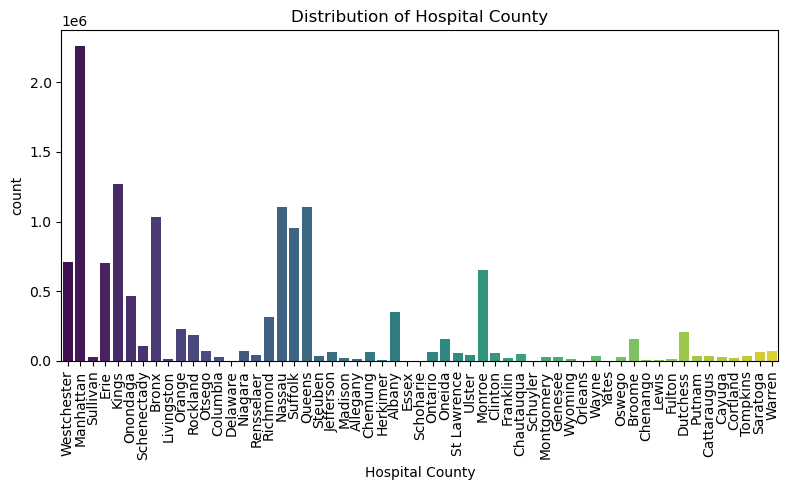

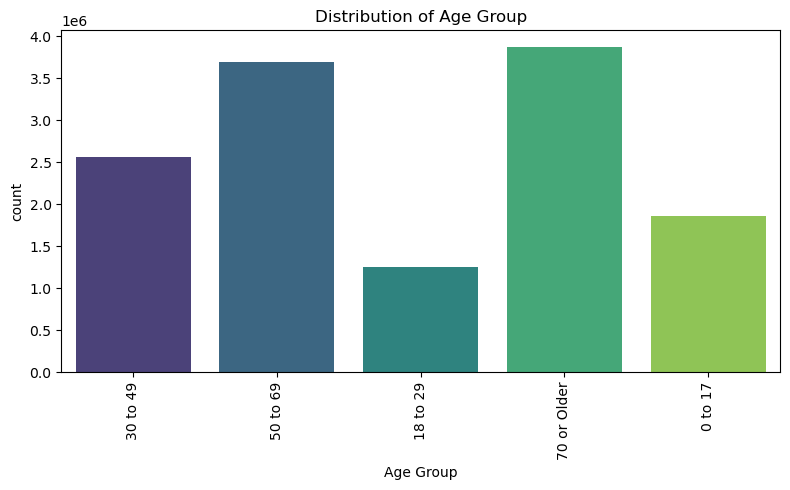

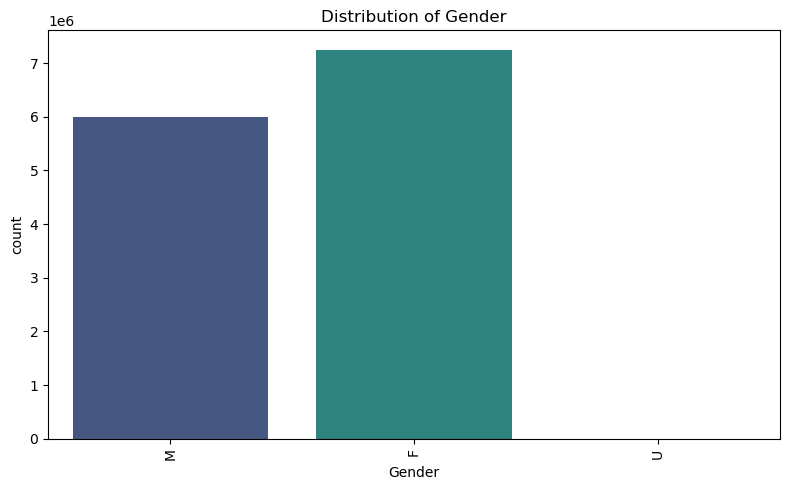

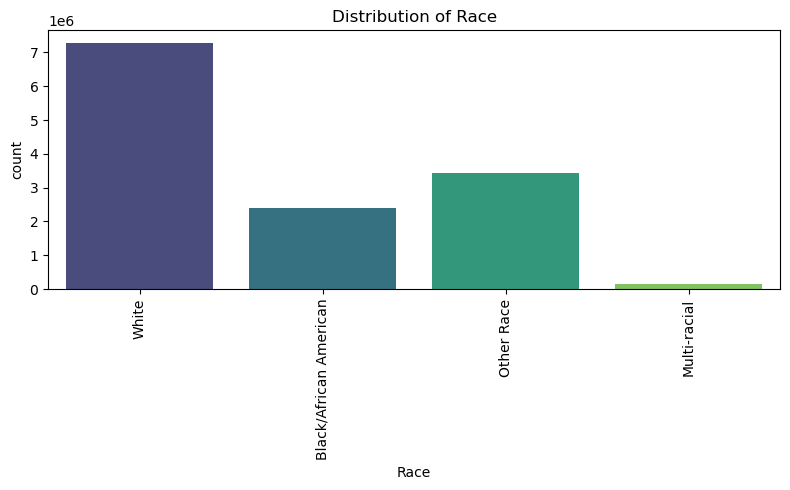

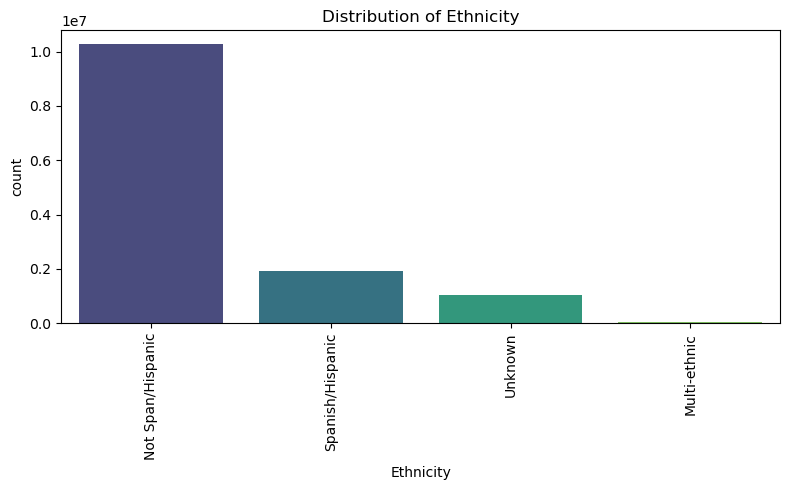

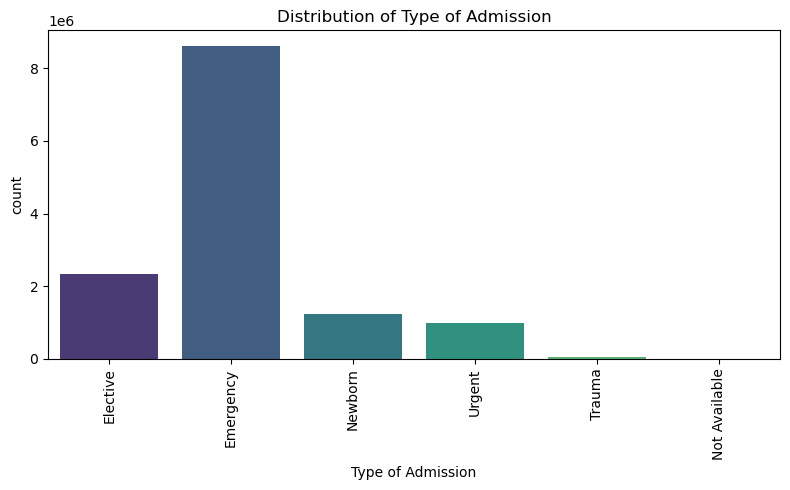

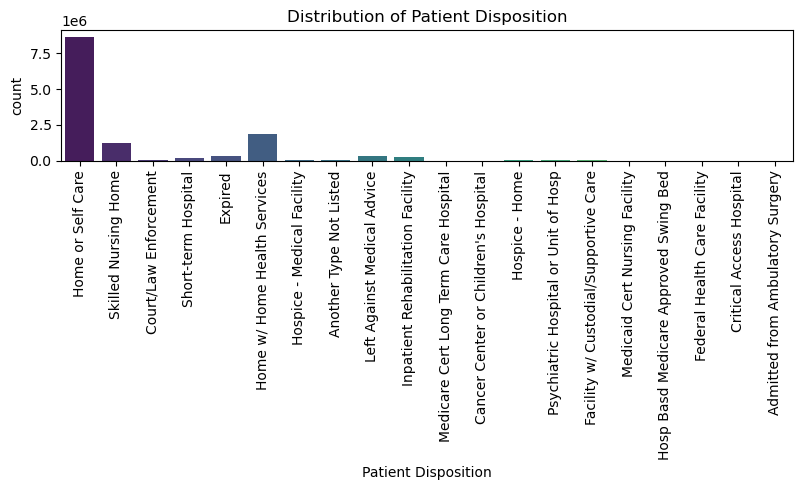

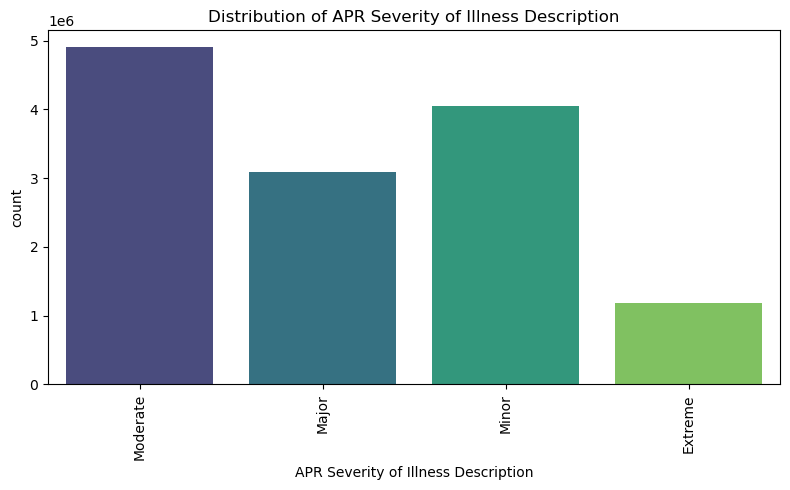

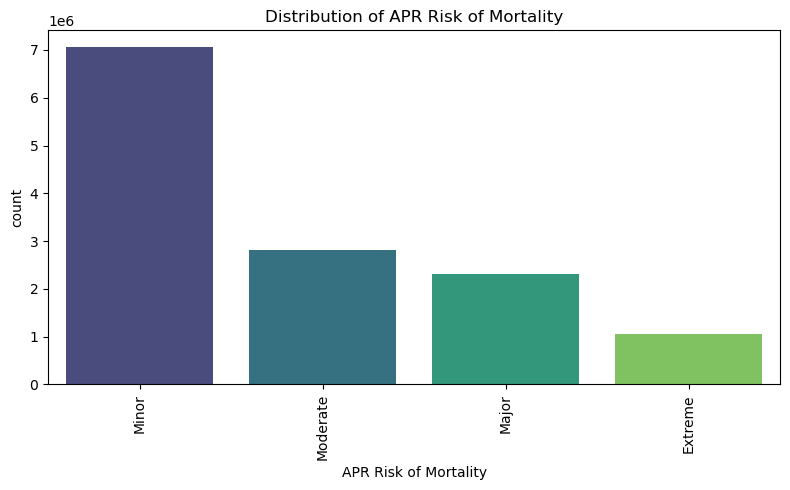

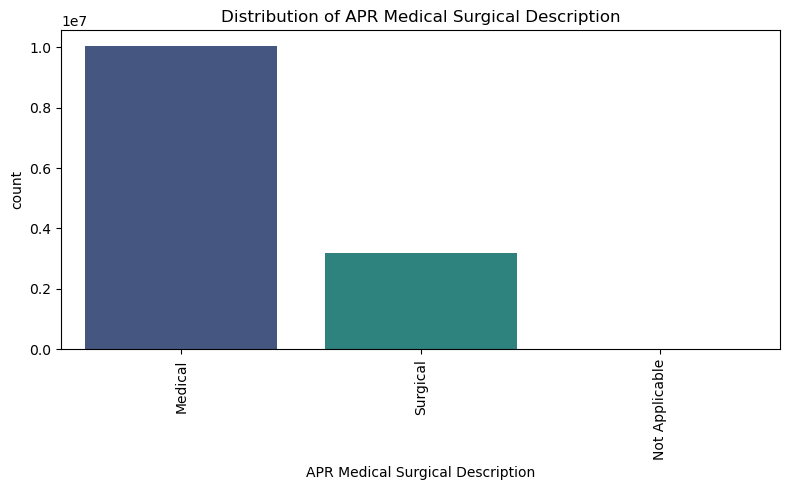

C:\Users\Fasih Munir\anaconda3\envs\principles_of_data_science\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  


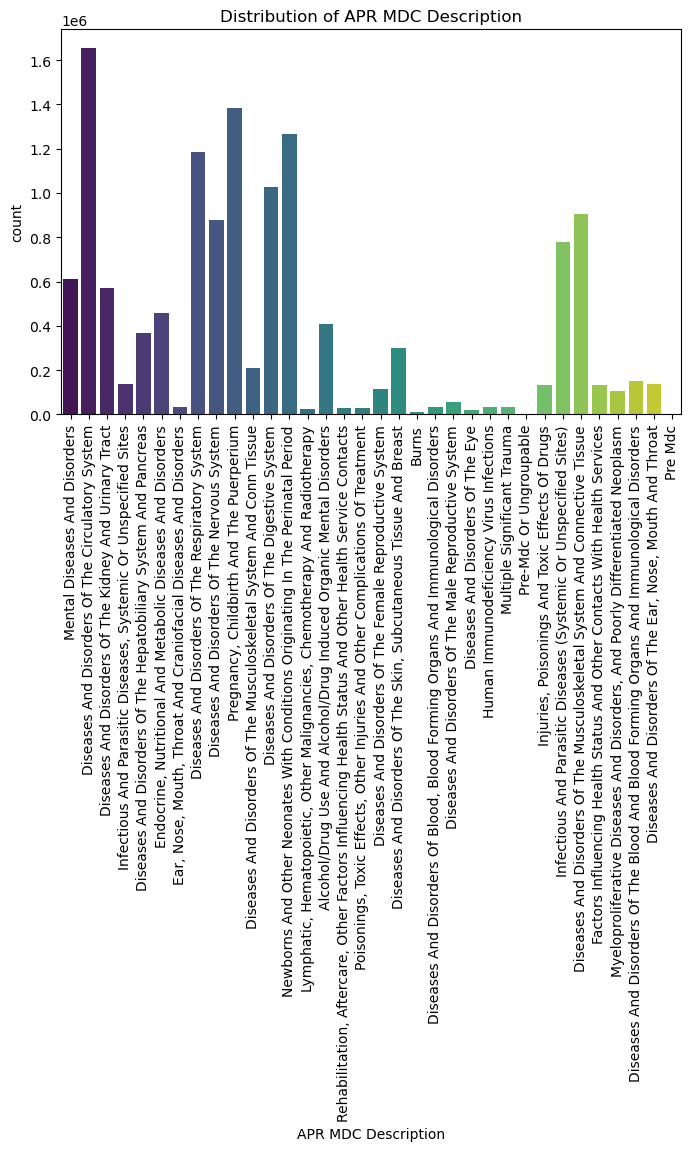

In [18]:
#we will take a look at a few categorical variables and observe their distribution
#this is done with respect to the number of discharges across all years

#on first run I noticed difference in proper case and all caps hence duplicates
df_all_years['APR MDC Description'] = df_all_years['APR MDC Description'].str.title()

categorical_distributions = ['Hospital County', 'Age Group', 'Gender', 'Race', 'Ethnicity', 'Type of Admission',
                            'Patient Disposition', 'APR Severity of Illness Description', 
                            'APR Risk of Mortality', 'APR Medical Surgical Description', 'APR MDC Description']

for variable in categorical_distributions:
    plt.figure(figsize=(8,5))
    sns.countplot(data = df_all_years, x = variable, palette = 'viridis')
    plt.title(f'Distribution of {variable}')
    plt.xticks(rotation = 90)
    plt.tight_layout()
    plt.show()

The county with the most number of discharges is Manhatten. This is double of the next highest county. There is a Right Skew.
Older age groups are discharged more compared to younger people.
More females are discharged compared to males.
More member of the white race are discharged. There is a Right Skew.
More member of the not spanish/hispanic communites are discharged. There is a right Right Skew.
Most admissions in hospitals are due to emergencies.
Most patients are discharged with some home care/self care.
Severity of illness is evenly distributed for moderate, major and minor. Extreme illnesses are uncommon but not rare.
Most risk of mortality is minor. It follows: minor > moderate > major > extreme. There is Right Skew.
Most surgical descriptions are medical ie less visits require surgiries.
Diseases and disorders of the circulatory system have the most number of discharges followed by pregnancy and childbirth.

None of the variables seem to have a normal distribution.

# Section 1 - Has It Become More Expensive to Be Sick

In [21]:
#we will create a charges per day variable to make the data easier to compare across discharges
#looking at total charges might not make sense when comparing charges for stays of greater than 1 week
#to stays of 2 days

df_all_years['Length of Stay'] = pd.to_numeric(df_all_years['Length of Stay'], errors='coerce')
df_all_years['Total Charges'] = pd.to_numeric(df_all_years['Total Charges'], errors='coerce')

df_all_years['Charges per Day'] = (df_all_years['Total Charges'] / df_all_years['Length of Stay']).round()
#df_all_years.head()

In [22]:
#just getting a quick look at the prices per illness across years
#there seem to be one or 2 duplicates but little cause of concern for now

#df_all_years['Charges per Day'] = df_all_years['Charges per Day'].astype(float)

illness_charge_pivot = df_all_years.pivot_table(index = 'APR MDC Description', 
                                           columns = 'Discharge Year', 
                                                 values = 'Charges per Day',
                                                 aggfunc = np.mean)
illness_charge_pivot

Discharge Year                                              2017  \
APR MDC Description                                                
Alcohol/Drug Use And Alcohol/Drug Induced Organ...   4461.822000   
Burns                                               12351.736176   
Diseases And Disorders Of Blood, Blood Forming ...  10614.364216   
Diseases And Disorders Of The Blood And Blood F...           NaN   
Diseases And Disorders Of The Circulatory System    18289.568640   
Diseases And Disorders Of The Digestive System      11112.843509   
Diseases And Disorders Of The Ear, Nose, Mouth ...           NaN   
Diseases And Disorders Of The Eye                   12507.352779   
Diseases And Disorders Of The Female Reproducti...  17637.933294   
Diseases And Disorders Of The Hepatobiliary Sys...  11661.006093   
Diseases And Disorders Of The Kidney And Urinar...  10794.670283   
Diseases And Disorders Of The Male Reproductive...  21902.775493   
Diseases And Disorders Of The Musculoskeletal S...  20695.321359   
Diseases And Disorders Of The Musculoskeletal S...           NaN   
Diseases And Disorders Of The Nervous System        13686.908547   
Diseases And Disorders Of The Respiratory System     9522.240052   
Diseases And Disorders Of The Skin, Subcutaneou...  10522.431348   
Ear, Nose, Mouth, Throat And Craniofacial Disea...  13102.571040   
Endocrine, Nutritional And Metabolic Diseases A...  13509.504363   
Factors Influencing Health Status And Other Con...           NaN   
Human Immunodeficiency Virus Infections              9131.896300   
Infectious And Parasitic Diseases (Systemic Or ...           NaN   
Infectious And Parasitic Diseases, Systemic Or ...   9576.583035   
Injuries, Poisonings And Toxic Effects Of Drugs              NaN   
Lymphatic, Hematopoietic, Other Malignancies, C...  12783.949519   
Mental Diseases And Disorders                        3645.144392   
Multiple Significant Trauma                         15456.518696   
Myeloproliferative Diseases And Disorders, And ...           NaN   
Newborns And Other Neonates With Conditions Ori...   4419.050290   
Poisonings, Toxic Effects, Other Injuries And O...  10823.815608   
Pre Mdc                                                      NaN   
Pre-Mdc Or Ungroupable                               6723.984456   
Pregnancy, Childbirth And The Puerperium             8027.547361   
Rehabilitation, Aftercare, Other Factors Influe...   8503.480839   

Discharge Year                                              2018  \
APR MDC Description                                                
Alcohol/Drug Use And Alcohol/Drug Induced Organ...   4696.132803   
Burns                                               12828.589010   
Diseases And Disorders Of Blood, Blood Forming ...           NaN   
Diseases And Disorders Of The Blood And Blood F...  11257.205348   
Diseases And Disorders Of The Circulatory System    20372.411629   
Diseases And Disorders Of The Digestive System      12013.909466   
Diseases And Disorders Of The Ear, Nose, Mouth ...  13753.011596   
Diseases And Disorders Of The Eye                   13885.241715   
Diseases And Disorders Of The Female Reproducti...  19662.391715   
Diseases And Disorders Of The Hepatobiliary Sys...  12541.793460   
Diseases And Disorders Of The Kidney And Urinar...  11534.160019   
Diseases And Disorders Of The Male Reproductive...  23272.613280   
Diseases And Disorders Of The Musculoskeletal S...           NaN   
Diseases And Disorders Of The Musculoskeletal S...  22843.193114   
Diseases And Disorders Of The Nervous System        15019.910726   
Diseases And Disorders Of The Respiratory System    10366.695168   
Diseases And Disorders Of The Skin, Subcutaneou...  11406.924589   
Ear, Nose, Mouth, Throat And Craniofacial Disea...           NaN   
Endocrine, Nutritional And Metabolic Diseases A...  14889.074865   
Factors Influencing Health Status And Other Con...   9269.673744   
Human Immunodeficiency Virus Infections             164

In [23]:
correlation_results = pd.DataFrame(columns=['Discharge Year', 'Spearman Correlation'])

for year in df_all_years['Discharge Year'].unique():
    data_year = df_all_years[df_all_years['Discharge Year'] == year]
    
    correlation = data_year[['Charges per Day', 'Length of Stay']].corr(method='spearman').iloc[0, 1]
    
    correlation_results = correlation_results.append({'Discharge Year': year, 'Spearman Correlation': correlation}, ignore_index=True)

correlation_results

Discharge Year  Spearman Correlation
0          2017.0             -0.220861
1          2018.0             -0.229986
2          2019.0             -0.244700
3          2020.0             -0.237266
4          2021.0             -0.249845
5          2022.0             -0.263029

Looks like there is a low negative correlation with Length of Stay and Charges per Day. A decreasing length leads to an increase in price and the correlation has gotten stronger over time.

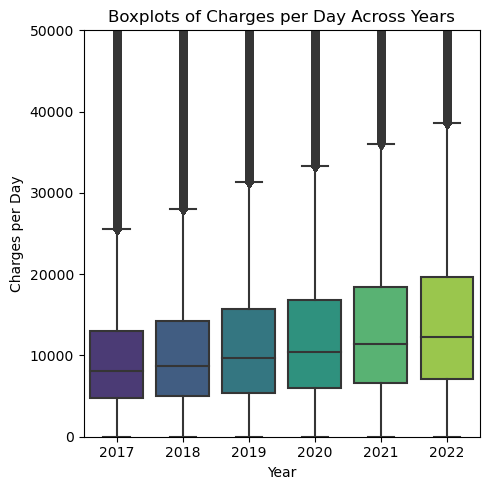

In [24]:
#here we have simply limited the y axis scale to show data up to a certain point making the boxes clearer

plt.figure(figsize = (5, 5))
sns.boxplot(data = df_all_years, x = df_all_years['Discharge Year'], y = df_all_years['Charges per Day'],
           palette = 'viridis')
plt.ylim(0, 50000)
plt.title('Boxplots of Charges per Day Across Years')
plt.xlabel('Year')
plt.ylabel('Charges per Day')
plt.tight_layout()
plt.show()

The median charges per day have increased steadly over the years including the overall iqr range given the box size.
This shows that the data is getting more dispersed (or variable over time). There are more differences between the low and high values. Data is also less clustered around the median. I would not say that uncertainty has increased
but it might be that there are more and more outliers each year that are casuing this dispersion. It might also just be the yearly inflation causing this upward movement.
2020 was a year that I was expecting the most fluctuation given that that was the covid year but it seems steady.
Lets dive in a little deeper and look at the charges for illness severity

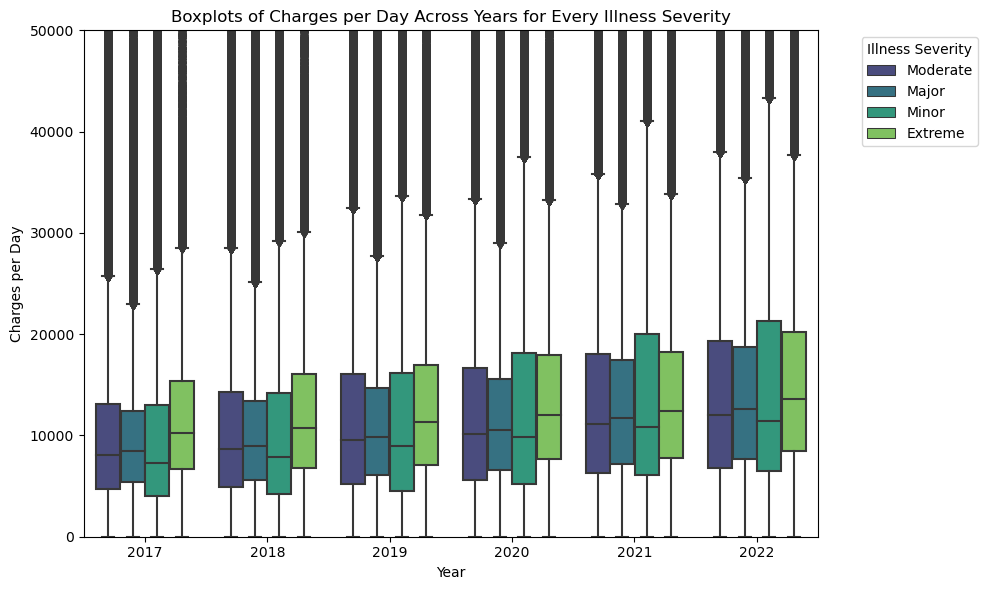

In [25]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_all_years, x='Discharge Year', y='Charges per Day', hue='APR Severity of Illness Description',
            palette='viridis')
plt.ylim(0, 50000)
plt.title('Boxplots of Charges per Day Across Years for Every Illness Severity')
plt.xlabel('Year')
plt.ylabel('Charges per Day')
plt.legend(title='Illness Severity', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#see pivot table that follows as well and then the comments post the pivot

In [26]:
severity_discharge_pivot = df_all_years.pivot_table(index = df_all_years['APR Severity of Illness Description'], 
                                           columns = df_all_years['Discharge Year'], aggfunc = 'size')
severity_discharge_pivot

Discharge Year                         2017    2018    2019    2020    2021  \
APR Severity of Illness Description                                           
Extreme                              138205  181037  234517  193514  230913   
Major                                536354  561010  577882  449642  467678   
Minor                                763664  719998  678060  647296  634612   
Moderate                             905106  890604  847556  761802  756539   

Discharge Year                         2022  
APR Severity of Illness Description          
Extreme                              209410  
Major                                493932  
Minor                                613780  
Moderate                             743879

In [27]:
#df_all_years['Charges per Day'] = df_all_years['Charges per Day'].astype(float)

severity_charge_pivot = df_all_years.pivot_table(index = 'APR Severity of Illness Description', 
                                           columns = 'Discharge Year', 
                                                 values = 'Charges per Day',
                                                 aggfunc = np.mean)
severity_charge_pivot

Discharge Year                               2017          2018          2019  \
APR Severity of Illness Description                                             
Extreme                              14415.782300  15140.211099  16111.449201   
Major                                10445.970581  11234.928773  12325.044896   
Minor                                11707.558290  12888.217438  14620.295260   
Moderate                             11465.132271  12629.066949  14159.421642   

Discharge Year                               2020          2021          2022  
APR Severity of Illness Description                                            
Extreme                              14895.021144  15204.151923  16736.159819  
Major                                13125.420415  14952.964219  16281.923919  
Minor                                16473.687624  18209.951129  19324.957796  
Moderate                             14948.448528  16489.418385  17853.588333

In [28]:
#df_all_years['Charges per Day'] = df_all_years['Charges per Day'].astype(float)

severity_stay_pivot = df_all_years.pivot_table(index = 'APR Severity of Illness Description', 
                                           columns = 'Discharge Year', 
                                                 values = 'Length of Stay',
                                                 aggfunc = np.mean)
severity_stay_pivot

Discharge Year                            2017       2018       2019  \
APR Severity of Illness Description                                    
Extreme                              13.986334  13.609303  12.374802   
Major                                 7.222544   6.751239   6.439347   
Minor                                 3.023157   2.972313   2.890762   
Moderate                              4.753055   4.620588   4.540172   

Discharge Year                            2020       2021       2022  
APR Severity of Illness Description                                   
Extreme                              13.485884  13.243420  13.748323  
Major                                 7.199151   7.190165   7.250465  
Minor                                 2.869147   2.848089   2.882807  
Moderate                              4.789444   4.774172   4.775514

In [29]:
prices_2017_minor = df_all_years.loc[(df_all_years['Discharge Year'] == 2017) & (df_all_years['APR Severity of Illness Description'] == 'Minor'), 'Charges per Day'].values
prices_2017_moderate = df_all_years.loc[(df_all_years['Discharge Year'] == 2017) & (df_all_years['APR Severity of Illness Description'] == 'Moderate'), 'Charges per Day'].values
prices_2017_major = df_all_years.loc[(df_all_years['Discharge Year'] == 2017) & (df_all_years['APR Severity of Illness Description'] == 'Major'), 'Charges per Day'].values
prices_2017_extreme = df_all_years.loc[(df_all_years['Discharge Year'] == 2017) & (df_all_years['APR Severity of Illness Description'] == 'Extreme'), 'Charges per Day'].values

prices_2018_minor = df_all_years.loc[(df_all_years['Discharge Year'] == 2018) & (df_all_years['APR Severity of Illness Description'] == 'Minor'), 'Charges per Day'].values
prices_2018_moderate = df_all_years.loc[(df_all_years['Discharge Year'] == 2018) & (df_all_years['APR Severity of Illness Description'] == 'Moderate'), 'Charges per Day'].values
prices_2018_major = df_all_years.loc[(df_all_years['Discharge Year'] == 2018) & (df_all_years['APR Severity of Illness Description'] == 'Major'), 'Charges per Day'].values
prices_2018_extreme = df_all_years.loc[(df_all_years['Discharge Year'] == 2018) & (df_all_years['APR Severity of Illness Description'] == 'Extreme'), 'Charges per Day'].values

prices_2019_minor = df_all_years.loc[(df_all_years['Discharge Year'] == 2019) & (df_all_years['APR Severity of Illness Description'] == 'Minor'), 'Charges per Day'].values
prices_2019_moderate = df_all_years.loc[(df_all_years['Discharge Year'] == 2019) & (df_all_years['APR Severity of Illness Description'] == 'Moderate'), 'Charges per Day'].values
prices_2019_major = df_all_years.loc[(df_all_years['Discharge Year'] == 2019) & (df_all_years['APR Severity of Illness Description'] == 'Major'), 'Charges per Day'].values
prices_2019_extreme = df_all_years.loc[(df_all_years['Discharge Year'] == 2019) & (df_all_years['APR Severity of Illness Description'] == 'Extreme'), 'Charges per Day'].values

prices_2020_minor = df_all_years.loc[(df_all_years['Discharge Year'] == 2020) & (df_all_years['APR Severity of Illness Description'] == 'Minor'), 'Charges per Day'].values
prices_2020_moderate = df_all_years.loc[(df_all_years['Discharge Year'] == 2020) & (df_all_years['APR Severity of Illness Description'] == 'Moderate'), 'Charges per Day'].values
prices_2020_major = df_all_years.loc[(df_all_years['Discharge Year'] == 2020) & (df_all_years['APR Severity of Illness Description'] == 'Major'), 'Charges per Day'].values
prices_2020_extreme = df_all_years.loc[(df_all_years['Discharge Year'] == 2020) & (df_all_years['APR Severity of Illness Description'] == 'Extreme'), 'Charges per Day'].values

prices_2021_minor = df_all_years.loc[(df_all_years['Discharge Year'] == 2021) & (df_all_years['APR Severity of Illness Description'] == 'Minor'), 'Charges per Day'].values
prices_2021_moderate = df_all_years.loc[(df_all_years['Discharge Year'] == 2021) & (df_all_years['APR Severity of Illness Description'] == 'Moderate'), 'Charges per Day'].values
prices_2021_major = df_all_years.loc[(df_all_years['Discharge Year'] == 2021) & (df_all_years['APR Severity of Illness Description'] == 'Major'), 'Charges per Day'].values
prices_2021_extreme = df_all_years.loc[(df_all_years['Discharge Year'] == 2021) & (df_all_years['APR Severity of Illness Description'] == 'Extreme'), 'Charges per Day'].values

prices_2022_minor = df_all_years.loc[(df_all_years['Discharge Year'] == 2022) & (df_all_years['APR Severity of Illness Description'] == 'Minor'), 'Charges per Day'].values
prices_2022_moderate = df_all_years.loc[(df_all_years['Discharge Year'] == 2022) & (df_all_years['APR Severity of Illness Description'] == 'Moderate'), 'Charges per Day'].values
prices_2022_major = df_all_years.loc[(df_all_years['Discharge Year'] == 2022) & (df_all_years['APR Severity of Illness Description'] == 'Major'), 'Charges per Day'].values
prices_2022_extreme = df_all_years.loc[(df_all_years['Discharge Year'] == 2022) & (df_all_years['APR Severity of Illness Description'] == 'Extreme'), 'Charges per Day'].values


In [30]:
prices_2017_minor = prices_2017_minor[~np.isnan(prices_2017_minor)]
prices_2017_moderate = prices_2017_moderate[~np.isnan(prices_2017_moderate)] 
prices_2017_major = prices_2017_major[~np.isnan(prices_2017_major)]
prices_2017_extreme = prices_2017_extreme[~np.isnan(prices_2017_extreme)] 

prices_2018_minor = prices_2018_minor[~np.isnan(prices_2018_minor)]
prices_2018_moderate = prices_2018_moderate[~np.isnan(prices_2018_moderate)] 
prices_2018_major = prices_2018_major[~np.isnan(prices_2018_major)]
prices_2018_extreme = prices_2018_extreme[~np.isnan(prices_2018_extreme)] 

prices_2019_minor = prices_2019_minor[~np.isnan(prices_2019_minor)]
prices_2019_moderate = prices_2019_moderate[~np.isnan(prices_2019_moderate)] 
prices_2019_major = prices_2019_major[~np.isnan(prices_2019_major)]
prices_2019_extreme = prices_2019_extreme[~np.isnan(prices_2019_extreme)] 

prices_2020_minor = prices_2020_minor[~np.isnan(prices_2020_minor)]
prices_2020_moderate = prices_2020_moderate[~np.isnan(prices_2020_moderate)] 
prices_2020_major = prices_2020_major[~np.isnan(prices_2020_major)]
prices_2020_extreme = prices_2020_extreme[~np.isnan(prices_2020_extreme)] 

prices_2021_minor = prices_2021_minor[~np.isnan(prices_2021_minor)]
prices_2021_moderate = prices_2021_moderate[~np.isnan(prices_2021_moderate)] 
prices_2021_major = prices_2021_major[~np.isnan(prices_2021_major)]
prices_2021_extreme = prices_2021_extreme[~np.isnan(prices_2021_extreme)] 

prices_2022_minor = prices_2022_minor[~np.isnan(prices_2022_minor)]
prices_2022_moderate = prices_2022_moderate[~np.isnan(prices_2022_moderate)] 
prices_2022_major = prices_2022_major[~np.isnan(prices_2022_major)]
prices_2022_extreme = prices_2022_extreme[~np.isnan(prices_2022_extreme)] 

In [32]:
#https://bmcmedresmethodol.biomedcentral.com/articles/10.1186/1471-2288-12-78

unique_years = df_all_years['Discharge Year'].unique()

results = {}

severity_levels = ['minor', 'moderate', 'major', 'extreme']

#loop
for year in unique_years:
    level_pairs = combinations(severity_levels, 2)
    
    for level1, level2 in level_pairs:
            
            var1 = f"prices_{year}_{level1}"
            var2 = f"prices_{year}_{level2}"
            
            stat, p_value = ttest_ind(locals()[var1], locals()[var2], equal_var=False) #welch test for unequal variance
            #unequal variance seen from the boxplot
            #https://journals.sagepub.com/doi/full/10.1177/0004563221992088
            
            is_5_percent = p_value <= 0.05

            results[f"{var1} vs {var2}"] = {
            'Statistic': stat,
            'P-Value': f"{p_value:.5f}",
            'Significant_5%': is_5_percent
        }
results_df = pd.DataFrame(results).T
results_df

Statistic  P-Value Significant_5%
prices_2017_minor vs prices_2017_moderate    10.454171  0.00000           True
prices_2017_minor vs prices_2017_major       54.393622  0.00000           True
prices_2017_minor vs prices_2017_extreme    -45.175356  0.00000           True
prices_2017_moderate vs prices_2017_major    50.175582  0.00000           True
prices_2017_moderate vs prices_2017_extreme -50.100856  0.00000           True
prices_2017_major vs prices_2017_extreme    -67.403892  0.00000           True
prices_2018_minor vs prices_2018_moderate     9.475682  0.00000           True
prices_2018_minor vs prices_2018_major       62.169602  0.00000           True
prices_2018_minor vs prices_2018_extreme    -37.933196  0.00000           True
prices_2018_moderate vs prices_2018_major    59.551158  0.00000           True
prices_2018_moderate vs prices_2018_extreme -43.286911  0.00000           True
prices_2018_major vs prices_2018_extreme    -67.730472  0.00000           True
prices_2019_minor vs prices_2019_moderate    13.933307  0.00000           True
prices_2019_minor vs prices_2019_major       73.347364  0.00000           True
prices_2019_minor vs prices_2019_extreme    -24.885263  0.00000           True
prices_2019_moderate vs prices_2019_major    68.528387  0.00000           True
prices_2019_moderate vs prices_2019_extreme -33.838031  0.00000           True
prices_2019_major vs prices_2019_extreme    -66.799429  0.00000           True
prices_2020_minor vs prices_2020_moderate    40.066442  0.00000           True
prices_2020_minor vs prices_2020_major       90.548956  0.00000           True
prices_2020_minor vs prices_2020_extreme     35.369206  0.00000           True
prices_2020_moderate vs prices_2020_major    55.875737  0.00000           True
prices_2020_moderate vs prices_2020_extreme   1.299885  0.19364          False
prices_2020_major vs prices_2020_extreme     -44.13641  0.00000           True
prices_2021_minor vs prices_2021_moderate    41.193002  0.00000           True
prices_2021_minor vs prices_2021_major       78.926804  0.00000           True
prices_2021_minor vs prices_2021_extreme     68.470942  0.00000           True
prices_2021_moderate vs prices_2021_major    40.748903  0.00000           True
prices_2021_moderate vs prices_2021_extreme  31.680113  0.00000           True
prices_2021_major vs prices_2021_extreme     -6.271311  0.00000           True
prices_2022_minor vs prices_2022_moderate    32.527326  0.00000           True
prices_2022_minor vs prices_2022_major       68.944702  0.00000           True
prices_2022_minor vs prices_2022_extreme     53.896546  0.00000           True
prices_2022_moderate vs prices_2022_major    38.299837  0.00000           True
prices_2022_moderate vs prices_2022_extreme   24.72225  0.00000           True
prices_2022_major vs prices_2022_extreme    -10.299933  0.00000           True

In [33]:
x = df_all_years[
    #(df_all_years['APR Severity of Illness Description'] == 'Minor') &
    (df_all_years['Discharge Year'] == 2022) 
]

x_pivot = x.pivot_table(index = 'Combined Diagnosis Description', 
                                           columns = 'APR Severity of Illness Description', 
                                                 values = 'Charges per Day',
                                                 aggfunc = [np.median, np.size])

x_pivot_table = x_pivot.reset_index()

x_pivot_table

Combined Diagnosis Description  \
APR Severity of Illness Description                                                      
0                                                                     Abdominal hernia   
1                                    Abdominal pain and other digestive/abdomen sig...   
2                                                  Abnormal findings without diagnosis   
3                                                    Acquired absence of limb or organ   
4                                                Acquired deformities (excluding foot)   
..                                                                                 ...   
475                                                           Urinary tract infections   
476                                                    Uveitis and ocular inflammation   
477                                                  Varicose veins of lower extremity   
478                                                              Vesicoureteral reflux   
479                                                                    Viral infection   

                                      median                             \
APR Severity of Illness Description  Extreme    Major    Minor Moderate   
0                                    15678.0  16243.0  25352.0  17576.5   
1                                    13704.0  13916.0  15275.5  14038.0   
2                                    13523.0  13244.0  14750.0  13900.5   
3                                        NaN  72318.0  42400.0  59337.0   
4                                    26365.0  31716.5  35343.0  33789.5   
..                                       ...      ...      ...      ...   
475                                  11827.0  10904.5  11266.0  10499.5   
476                                  11976.0  14136.5  14378.0  11780.0   
477                                  12449.0  10030.0  14162.0  12395.0   
478                                      NaN  14632.5  30700.0  25515.0   
479                                  16986.0  14770.0  11726.0  12886.0   

                                       size                           
APR Severity of Illness Description Extreme   Major   Minor Moderate  
0                                     512.0  1494.0  4426.0   3253.0  
1                                      73.0   699.0  1462.0   1697.0  
2                                     172.0   629.0  1321.0   1070.0  
3                                       NaN     1.0    18.0      4.0  
4                                      11.0    74.0   264.0    251.0  
..                                      ...     ...     ...      ...  
475                                  1094.0  8635.0  4656.0  13137.0  
476                                     6.0    32.0    14.0     57.0  
477                                    11.0   122.0    27.0    239.0  
478                                     NaN     2.0    93.0      7.0  
479                                   139.0   795.0  1067.0   1455.0  

[480 rows x 9 columns]

Looking at the boxplot, the spread for minor illnesses has increased dramatically over time. This means that over time there is more variability in the spread ie more observations that are tending to fall on the higher side of the charges. The other illnesses categories have increased but look more stable with no major changes.
The significance tests also show that the difference in pricing for the illness categories are not due to random chance especially for the curious case of minor illnesses in 2022.

It might mean there are more unusal cases for minor illnesses coming in that is causing the increase in price. Different kinds of equipment, more expensive equipment or treatments and more time spent by hospital staff. Look at index 29 for Appendicitis in x_pivot_table

For minor cases, the length of stay has steadily decreased over time and given the weak correlation with length of stay and daily charge this might make sense. Although note that correlation is not causation

So it seems that having a minor illness can result in more expensive treatment in recent years. It has gotten more expensive to be sick with minor illnesses

# Section 2 - Is It More Expensive For Some Groups of People to Acess the Care They Need?

Building on the thinking for the Minor Illnesses (highest charge, shortest stay and second highest discharges), are there groups of people that pay more for minor illnesses compared to others? Are these differences significant?

In [34]:
pd.set_option('display.max_rows', None)

df_minor_notU = df_all_years.loc[(df_all_years['APR Severity of Illness Description'] == 'Minor') & 
                           (df_all_years['Gender'] != 'U')]

people_charge_pivot = df_minor_notU.pivot_table(index = [
    #'Age Group', 
    #'Gender', 
    #'Race', 
    'Ethnicity'], 
                                           columns = 'Discharge Year', 
                                                 values = 'Charges per Day',
                                                 aggfunc = [np.mean, np.size])
people_charge_pivot

mean                                            \
Discharge Year             2017          2018          2019          2020   
Ethnicity                                                                   
Multi-ethnic       12046.062003  11997.169997  14134.898215  18659.822925   
Not Span/Hispanic  12080.926360  13232.889139  15133.304702  16997.196612   
Spanish/Hispanic   11099.367215  12450.630379  13910.821005  15645.381126   
Unknown             8979.760288  10372.997235  11329.862405  13510.907390   

                                                 size                          \
Discharge Year             2021          2022    2017    2018    2019    2020   
Ethnicity                                                                       
Multi-ethnic       20965.916073  22684.956280    3145    3553    2634    1265   
Not Span/Hispanic  18855.338466  20391.661580  592287  549277  513207  486351   
Spanish/Hispanic   17752.022645  18748.403535  111736  112875  105427  101298   
Unknown            14745.739973  14386.557628   56461   54254   56723   58304   

                                   
Discharge Year       2021    2022  
Ethnicity                          
Multi-ethnic         1263    1258  
Not Span/Hispanic  453752  423424  
Spanish/Hispanic   108463  109549  
Unknown             71063   79429

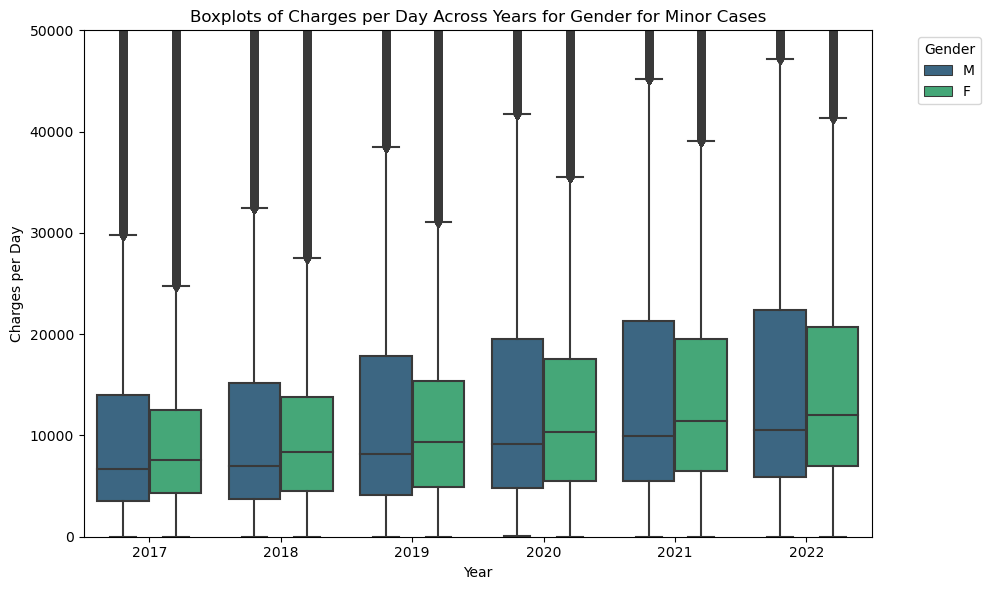

In [35]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_minor_notU, x='Discharge Year', y='Charges per Day', hue='Gender',
            palette='viridis')
plt.ylim(0, 50000)
plt.title('Boxplots of Charges per Day Across Years for Gender for Minor Cases')
plt.xlabel('Year')
plt.ylabel('Charges per Day')
plt.legend(title='Gender', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Female median charges are higher than male median charges although their overall spread is smaller. This could be because of specific illnesses related to them such as complications during pregnancy

The boxes overall show a steady increase and stable dispersion ie no dramatic shifts

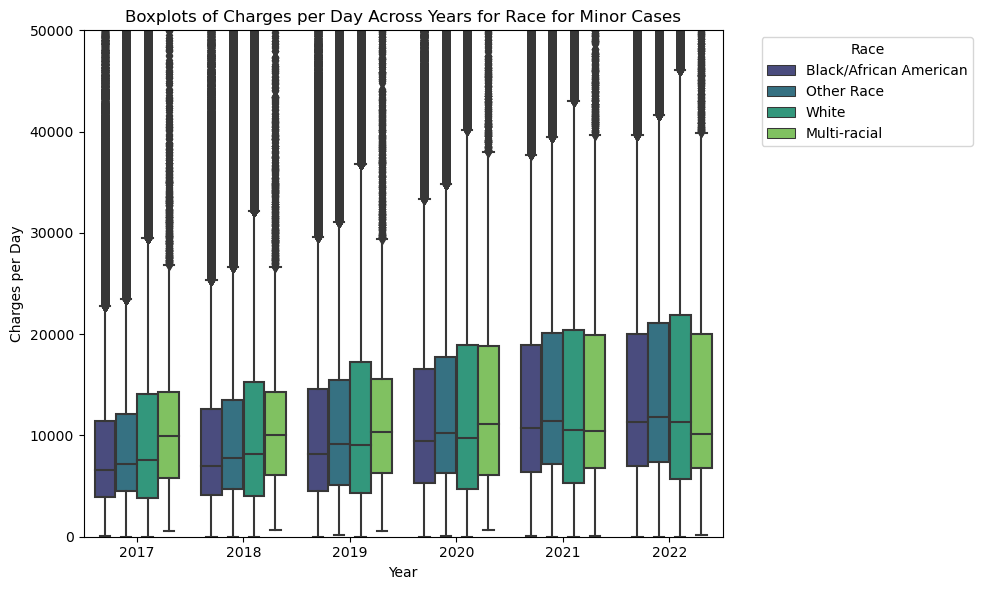

In [36]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_minor_notU, x='Discharge Year', y='Charges per Day', hue='Race',
            palette='viridis')
plt.ylim(0, 50000)
plt.title('Boxplots of Charges per Day Across Years for Race for Minor Cases')
plt.xlabel('Year')
plt.ylabel('Charges per Day')
plt.legend(title='Race', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

The dispersion in the boxes above along with the medians seem to have smoothed at over time with other races having a similar median coompared to multi-racial groups. Could be because of changing policy measures over time that made resource allocation more equitable

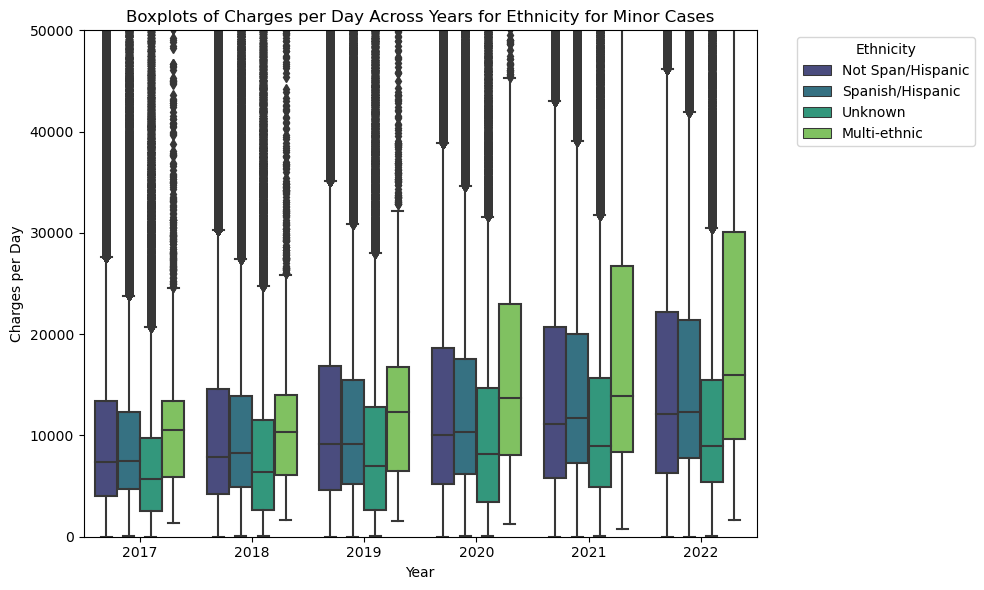

In [37]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_minor_notU, x='Discharge Year', y='Charges per Day', hue='Ethnicity',
            palette='viridis')
plt.ylim(0, 50000)
plt.title('Boxplots of Charges per Day Across Years for Ethnicity for Minor Cases')
plt.xlabel('Year')
plt.ylabel('Charges per Day')
plt.legend(title='Ethnicity', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

The dispersion for the multi ethnic is much more dramatic compared to the rest of the groups. They have always paid a higher median value that has only gotten larger and over time their variability has also increased. There might be more and more outlier cases here that require specific care. Similar thinking to the minor dispersion we saw in section 1

In [38]:
prices_2017_minor_multiethnic = df_all_years.loc[(df_all_years['Discharge Year'] == 2017) & (df_all_years['APR Severity of Illness Description'] == 'Minor') & (df_all_years['Ethnicity'] == 'Multi-ethnic'), 'Charges per Day'].values
prices_2017_minor_unknown = df_all_years.loc[(df_all_years['Discharge Year'] == 2017) & (df_all_years['APR Severity of Illness Description'] == 'Minor') & (df_all_years['Ethnicity'] == 'Unknown'), 'Charges per Day'].values
prices_2017_minor_notspan = df_all_years.loc[(df_all_years['Discharge Year'] == 2017) & (df_all_years['APR Severity of Illness Description'] == 'Minor') & (df_all_years['Ethnicity'] == 'Not Span/Hispanic'), 'Charges per Day'].values
prices_2017_minor_span = df_all_years.loc[(df_all_years['Discharge Year'] == 2017) & (df_all_years['APR Severity of Illness Description'] == 'Minor') & (df_all_years['Ethnicity'] == 'Spanish/Hispanic'), 'Charges per Day'].values

prices_2018_minor_multiethnic = df_all_years.loc[(df_all_years['Discharge Year'] == 2018) & (df_all_years['APR Severity of Illness Description'] == 'Minor') & (df_all_years['Ethnicity'] == 'Multi-ethnic'), 'Charges per Day'].values
prices_2018_minor_unknown = df_all_years.loc[(df_all_years['Discharge Year'] == 2018) & (df_all_years['APR Severity of Illness Description'] == 'Minor') & (df_all_years['Ethnicity'] == 'Unknown'), 'Charges per Day'].values
prices_2018_minor_notspan = df_all_years.loc[(df_all_years['Discharge Year'] == 2018) & (df_all_years['APR Severity of Illness Description'] == 'Minor') & (df_all_years['Ethnicity'] == 'Not Span/Hispanic'), 'Charges per Day'].values
prices_2018_minor_span = df_all_years.loc[(df_all_years['Discharge Year'] == 2018) & (df_all_years['APR Severity of Illness Description'] == 'Minor') & (df_all_years['Ethnicity'] == 'Spanish/Hispanic'), 'Charges per Day'].values

prices_2019_minor_multiethnic = df_all_years.loc[(df_all_years['Discharge Year'] == 2019) & (df_all_years['APR Severity of Illness Description'] == 'Minor') & (df_all_years['Ethnicity'] == 'Multi-ethnic'), 'Charges per Day'].values
prices_2019_minor_unknown = df_all_years.loc[(df_all_years['Discharge Year'] == 2019) & (df_all_years['APR Severity of Illness Description'] == 'Minor') & (df_all_years['Ethnicity'] == 'Unknown'), 'Charges per Day'].values
prices_2019_minor_notspan = df_all_years.loc[(df_all_years['Discharge Year'] == 2019) & (df_all_years['APR Severity of Illness Description'] == 'Minor') & (df_all_years['Ethnicity'] == 'Not Span/Hispanic'), 'Charges per Day'].values
prices_2019_minor_span = df_all_years.loc[(df_all_years['Discharge Year'] == 2019) & (df_all_years['APR Severity of Illness Description'] == 'Minor') & (df_all_years['Ethnicity'] == 'Spanish/Hispanic'), 'Charges per Day'].values

prices_2020_minor_multiethnic = df_all_years.loc[(df_all_years['Discharge Year'] == 2020) & (df_all_years['APR Severity of Illness Description'] == 'Minor') & (df_all_years['Ethnicity'] == 'Multi-ethnic'), 'Charges per Day'].values
prices_2020_minor_unknown = df_all_years.loc[(df_all_years['Discharge Year'] == 2020) & (df_all_years['APR Severity of Illness Description'] == 'Minor') & (df_all_years['Ethnicity'] == 'Unknown'), 'Charges per Day'].values
prices_2020_minor_notspan = df_all_years.loc[(df_all_years['Discharge Year'] == 2020) & (df_all_years['APR Severity of Illness Description'] == 'Minor') & (df_all_years['Ethnicity'] == 'Not Span/Hispanic'), 'Charges per Day'].values
prices_2020_minor_span = df_all_years.loc[(df_all_years['Discharge Year'] == 2020) & (df_all_years['APR Severity of Illness Description'] == 'Minor') & (df_all_years['Ethnicity'] == 'Spanish/Hispanic'), 'Charges per Day'].values

prices_2021_minor_multiethnic = df_all_years.loc[(df_all_years['Discharge Year'] == 2021) & (df_all_years['APR Severity of Illness Description'] == 'Minor') & (df_all_years['Ethnicity'] == 'Multi-ethnic'), 'Charges per Day'].values
prices_2021_minor_unknown = df_all_years.loc[(df_all_years['Discharge Year'] == 2021) & (df_all_years['APR Severity of Illness Description'] == 'Minor') & (df_all_years['Ethnicity'] == 'Unknown'), 'Charges per Day'].values
prices_2021_minor_notspan = df_all_years.loc[(df_all_years['Discharge Year'] == 2021) & (df_all_years['APR Severity of Illness Description'] == 'Minor') & (df_all_years['Ethnicity'] == 'Not Span/Hispanic'), 'Charges per Day'].values
prices_2021_minor_span = df_all_years.loc[(df_all_years['Discharge Year'] == 2021) & (df_all_years['APR Severity of Illness Description'] == 'Minor') & (df_all_years['Ethnicity'] == 'Spanish/Hispanic'), 'Charges per Day'].values

prices_2022_minor_multiethnic = df_all_years.loc[(df_all_years['Discharge Year'] == 2022) & (df_all_years['APR Severity of Illness Description'] == 'Minor') & (df_all_years['Ethnicity'] == 'Multi-ethnic'), 'Charges per Day'].values
prices_2022_minor_unknown = df_all_years.loc[(df_all_years['Discharge Year'] == 2022) & (df_all_years['APR Severity of Illness Description'] == 'Minor') & (df_all_years['Ethnicity'] == 'Unknown'), 'Charges per Day'].values
prices_2022_minor_notspan = df_all_years.loc[(df_all_years['Discharge Year'] == 2022) & (df_all_years['APR Severity of Illness Description'] == 'Minor') & (df_all_years['Ethnicity'] == 'Not Span/Hispanic'), 'Charges per Day'].values
prices_2022_minor_span = df_all_years.loc[(df_all_years['Discharge Year'] == 2022) & (df_all_years['APR Severity of Illness Description'] == 'Minor') & (df_all_years['Ethnicity'] == 'Spanish/Hispanic'), 'Charges per Day'].values

In [39]:
prices_2017_minor_multiethnic = prices_2017_minor_multiethnic[~np.isnan(prices_2017_minor_multiethnic)]
prices_2017_minor_unknown = prices_2017_minor_unknown[~np.isnan(prices_2017_minor_unknown)] 
prices_2017_minor_notspan = prices_2017_minor_notspan[~np.isnan(prices_2017_minor_notspan)]
prices_2017_minor_span = prices_2017_minor_span[~np.isnan(prices_2017_minor_span)] 

prices_2018_minor_multiethnic = prices_2018_minor_multiethnic[~np.isnan(prices_2018_minor_multiethnic)]
prices_2018_minor_unknown = prices_2018_minor_unknown[~np.isnan(prices_2018_minor_unknown)] 
prices_2018_minor_notspan = prices_2018_minor_notspan[~np.isnan(prices_2018_minor_notspan)]
prices_2018_minor_span = prices_2018_minor_span[~np.isnan(prices_2018_minor_span)] 

prices_2019_minor_multiethnic = prices_2019_minor_multiethnic[~np.isnan(prices_2019_minor_multiethnic)]
prices_2019_minor_unknown = prices_2019_minor_unknown[~np.isnan(prices_2019_minor_unknown)] 
prices_2019_minor_notspan = prices_2019_minor_notspan[~np.isnan(prices_2019_minor_notspan)]
prices_2019_minor_span = prices_2019_minor_span[~np.isnan(prices_2019_minor_span)] 

prices_2020_minor_multiethnic = prices_2020_minor_multiethnic[~np.isnan(prices_2020_minor_multiethnic)]
prices_2020_minor_unknown = prices_2020_minor_unknown[~np.isnan(prices_2020_minor_unknown)] 
prices_2020_minor_notspan = prices_2020_minor_notspan[~np.isnan(prices_2020_minor_notspan)]
prices_2020_minor_span = prices_2020_minor_span[~np.isnan(prices_2020_minor_span)] 

prices_2021_minor_multiethnic = prices_2021_minor_multiethnic[~np.isnan(prices_2021_minor_multiethnic)]
prices_2021_minor_unknown = prices_2021_minor_unknown[~np.isnan(prices_2021_minor_unknown)] 
prices_2021_minor_notspan = prices_2021_minor_notspan[~np.isnan(prices_2021_minor_notspan)]
prices_2021_minor_span = prices_2021_minor_span[~np.isnan(prices_2021_minor_span)] 

prices_2022_minor_multiethnic = prices_2022_minor_multiethnic[~np.isnan(prices_2022_minor_multiethnic)]
prices_2022_minor_unknown = prices_2022_minor_unknown[~np.isnan(prices_2022_minor_unknown)] 
prices_2022_minor_notspan = prices_2022_minor_notspan[~np.isnan(prices_2022_minor_notspan)]
prices_2022_minor_span = prices_2022_minor_span[~np.isnan(prices_2022_minor_span)] 

In [40]:
results2 = {}

ethnicities = ['multiethnic', 'unknown', 'notspan', 'span']

#loop
for year in unique_years:
    ethnicity_pairs = combinations(ethnicities, 2)
    
    for level1, level2 in ethnicity_pairs:
            
            var1 = f"prices_{year}_minor_{level1}"
            var2 = f"prices_{year}_minor_{level2}"
            
            t_stat, p_value = ttest_ind(locals()[var1], locals()[var2], equal_var=False)
            
            is_5_percent = p_value <= 0.05

            results2[f"{var1} vs {var2}"] = {
            'Statistic': t_stat,
            'P-Value': f"{p_value:.5f}",
            'Significant_5%': is_5_percent
        }
results2_df = pd.DataFrame(results2).T
results2_df

Statistic  P-Value  \
prices_2017_minor_multiethnic vs prices_2017_mi...  18.260274  0.00000   
prices_2017_minor_multiethnic vs prices_2017_mi...  -0.214413  0.83024   
prices_2017_minor_multiethnic vs prices_2017_mi...   5.743718  0.00000   
prices_2017_minor_unknown vs prices_2017_minor_... -55.290123  0.00000   
prices_2017_minor_unknown vs prices_2017_minor_... -32.152657  0.00000   
prices_2017_minor_notspan vs prices_2017_minor_...   21.26912  0.00000   
prices_2018_minor_multiethnic vs prices_2018_mi...   9.821362  0.00000   
prices_2018_minor_multiethnic vs prices_2018_mi...  -7.947284  0.00000   
prices_2018_minor_multiethnic vs prices_2018_mi...  -2.820912  0.00481   
prices_2018_minor_unknown vs prices_2018_minor_... -42.679125  0.00000   
prices_2018_minor_unknown vs prices_2018_minor_... -26.614934  0.00000   
prices_2018_minor_notspan vs prices_2018_minor_...  14.554523  0.00000   
prices_2019_minor_multiethnic vs prices_2019_mi...  12.330925  0.00000   
prices_2019_minor_multiethnic vs prices_2019_mi...  -4.834588  0.00000   
prices_2019_minor_multiethnic vs prices_2019_mi...   1.060314  0.28909   
prices_2019_minor_unknown vs prices_2019_minor_... -36.201318  0.00000   
prices_2019_minor_unknown vs prices_2019_minor_... -22.326504  0.00000   
prices_2019_minor_notspan vs prices_2019_minor_...  18.938146  0.00000   
prices_2020_minor_multiethnic vs prices_2020_mi...  11.160656  0.00000   
prices_2020_minor_multiethnic vs prices_2020_mi...   3.663537  0.00026   
prices_2020_minor_multiethnic vs prices_2020_mi...   6.596206  0.00000   
prices_2020_minor_unknown vs prices_2020_minor_... -36.260724  0.00000   
prices_2020_minor_unknown vs prices_2020_minor_...   -19.5187  0.00000   
prices_2020_minor_notspan vs prices_2020_minor_...  18.671467  0.00000   
prices_2021_minor_multiethnic vs prices_2021_mi...  10.766099  0.00000   
prices_2021_minor_multiethnic vs prices_2021_mi...   3.676875  0.00025   
prices_2021_minor_multiethnic vs prices_2021_mi...   5.576853  0.00000   
prices_2021_minor_unknown vs prices_2021_minor_... -47.162625  0.00000   
prices_2021_minor_unknown vs prices_2021_minor_... -29.495941  0.00000   
prices_2021_minor_notspan vs prices_2021_minor_...   14.32153  0.00000   
prices_2022_minor_multiethnic vs prices_2022_mi...  14.416802  0.00000   
prices_2022_minor_multiethnic vs prices_2022_mi...    3.99729  0.00007   
prices_2022_minor_multiethnic vs prices_2022_mi...    6.83227  0.00000   
prices_2022_minor_unknown vs prices_2022_minor_... -75.904625  0.00000   
prices_2022_minor_unknown vs prices_2022_minor_... -46.060706  0.00000   
prices_2022_minor_notspan vs prices_2022_minor_...  20.208102  0.00000   

                                                   Significant_5%  
prices_2017_minor_multiethnic vs prices_2017_mi...           True  
prices_2017_minor_multiethnic vs prices_2017_mi...          False  
prices_2017_minor_multiethnic vs prices_2017_mi...           True  
prices_2017_minor_unknown vs prices_2017_minor_...           True  
prices_2017_minor_unknown vs prices_2017_minor_...           True  
prices_2017_minor_notspan vs prices_2017_minor_...           True  
prices_2018_minor_multiethnic vs prices_2018_mi...           True  
prices_2018_minor_multiethnic vs prices_2018_mi...           True  
prices_2018_minor_multiethnic vs prices_2018_mi...           True  
prices_2018_minor_unknown vs prices_2018_minor_...           True  
prices_2018_minor_unknown vs prices_2018_minor_...           True  
prices_2018_minor_notspan vs prices_2018_minor_...           True  
prices_2019_minor_multiethnic vs prices_2019_mi...           True  
prices_2019_minor_multiethnic vs prices_2019_mi...           True  
prices_2019_minor_multiethnic vs prices_2019_mi...          False  
prices_2019_minor_unknown vs prices_2019_minor_...           True  
prices_2019_minor_unknown vs prices_2019_minor_...           True  
prices_2019_minor_notspan vs prices_2019_minor_...           True  
prices_2020_minor_mul

Looking at the significance tests at the 5% level, these differences are not by chance. Multi Ethnic groups are paying more for minor illnesses

In [41]:
xx = df_all_years[
    (df_all_years['APR Severity of Illness Description'] == 'Minor') &
    (df_all_years['Discharge Year'] == 2022) 
]

xx_pivot = xx.pivot_table(index = 'Combined Diagnosis Description', 
                                           columns = 'Ethnicity', 
                                                 values = 'Charges per Day',
                                                 aggfunc = [np.median, np.size])

xx_pivot_table = xx_pivot.reset_index()

xx_pivot_table

Combined Diagnosis Description       median  \
Ethnicity                                                    Multi-ethnic   
0                                           Abdominal hernia      34174.0   
1          Abdominal pain and other digestive/abdomen sig...      17437.5   
2                        Abnormal findings without diagnosis      22114.0   
3                          Acquired absence of limb or organ          NaN   
4                      Acquired deformities (excluding foot)          NaN   
5                                  Acquired foot deformities          NaN   
6                              Acute and chronic tonsillitis       6518.0   
7                        Acute and unspecified renal failure       8284.0   
8                                           Acute bronchitis       8289.0   
9                  Acute hemorrhagic cerebrovascular disease     108837.0   
10                               Acute myocardial infarction      16145.0   
11         Acute phlebitis; thrombophlebitis and thromboe...      10251.0   
12                              Acute posthemorrhagic anemia      10659.5   
13                                  Acute pulmonary embolism      10919.0   
14                             Acute rheumatic heart disease          NaN   
15                                 Alcohol-related disorders       7127.0   
16                                        Allergic reactions       8849.0   
17                  Allergic reactions, subsequent encounter          NaN   
18                   Amputation of a limb, initial encounter          NaN   
19                Amputation of a limb, subsequent encounter          NaN   
20         Amputation of other body parts, initial encounter          NaN   
21                                Anal and rectal conditions      30559.5   
22                 Anesthesia complications during pregnancy          NaN   
23                                       Antenatal screening          NaN   
24                        Anxiety and fear-related disorders      12650.0   
25         Aortic and peripheral arterial embolism or thr...      28430.0   
26         Aortic; peripheral; and visceral artery aneurysms      93825.0   
27                                           Aplastic anemia       9995.0   
28             Appendicitis and other appendiceal conditions      17786.0   
29                                      Arterial dissections      69993.0   
30                        Aseptic necrosis and osteonecrosis          NaN   
31                                    Aspiration pneumonitis          NaN   
32                                                    Asthma      10795.5   
33                      Atypical fracture, initial encounter          NaN   
34                                Autoinflammatory syndromes          NaN   
35                                      Bacterial infections          NaN   
36                                          Benign neoplasms      22125.5   
37                                       Benign ovarian cyst      35494.0   
38                                     Biliary tract disease      14827.0   
39                                     Biomechanical lesions          NaN   
40                             Bipolar and related disorders       6373.0   
41                                              Birth trauma          NaN   
42                              Blindness and vision defects          NaN   
43                                               Bone cancer      32791.0   
44                           Breast cancer - all other types      64029.0   
45           Breast cancer - ductal carcinoma in situ (DCIS)      19756.0   
46                     Burn and corrosion, initial encounter          NaN   
47                 Burns and corrosion, subsequent encounter          NaN   
48                                               CNS abscess          NaN   
49                                                  COVID-19       9818.0   
50                        

Scrolling through the table, Index 0 tells the story of the rest of the table where while there are small counts of multi ethnic people in the data they are paying abnoramally more for illnesses compared to other ethnicities. This might relate back to research done here https://pubmed.ncbi.nlm.nih.gov/37061988/ where the research found that non hispanic black patients had higher charges than others. There might be complications specific to the multi ethnic groups causing the dispersion

Below we will use a K means cluster on multi ethnic groups with minor illnesses for the most recent year of 2022. The reason to use the most recent year is to ensure that the most up to date health interventions and policies are being employed for patients. The most recent year will also give a better idea of what is currently happening and what may (or may not) continue happen in the next year

In [42]:
multiethnic_minor_2022_data = df_all_years[
    (df_all_years['Ethnicity'] == 'Multi-ethnic') &
    (df_all_years['APR Severity of Illness Description'] == 'Minor') &
    (df_all_years['Discharge Year'] == 2022)
][['Length of Stay', 'Charges per Day']].dropna()  # Selecting columns and dropping NaN values if any

multiethnic_minor_2022_data.head()

Length of Stay  Charges per Day
11179487             4.0          20047.0
11181179             3.0           7158.0
11183330             2.0          43035.0
11188879             2.0          19219.0
11189813             6.0          18088.0

In [43]:
scaler = StandardScaler()
cluster_scaled = scaler.fit_transform(multiethnic_minor_2022_data)

C:\Users\Fasih Munir\anaconda3\envs\principles_of_data_science\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  "KMeans is known to have a memory leak on Windows "


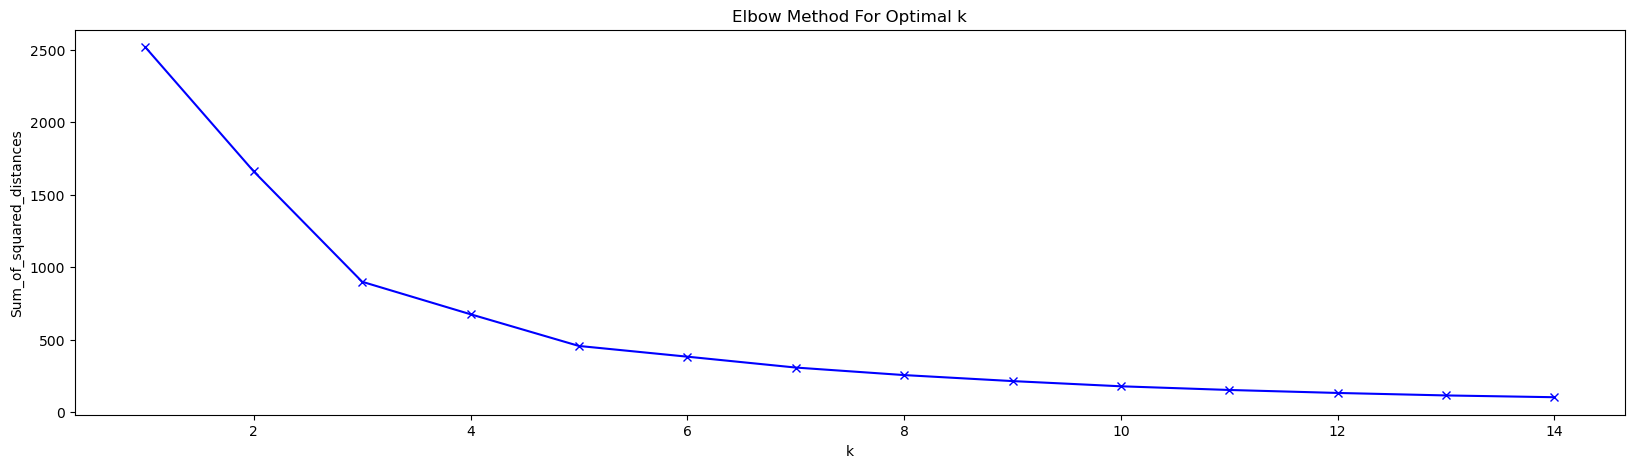

In [44]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(cluster_scaled)
    Sum_of_squared_distances.append(km.inertia_)
plt.figure(figsize=(20,5))
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

#the elbow method shows us that the best number of clusters is 4. That is where the curve kinks and changes

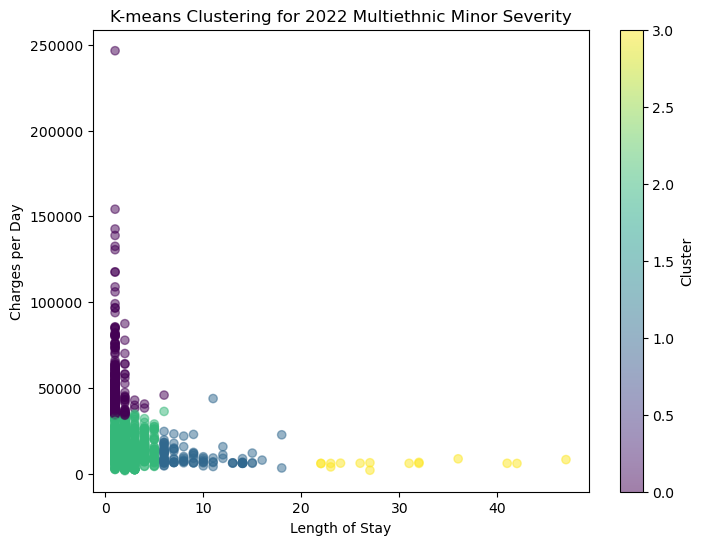

          Length of Stay  Charges per Day  Cluster
11179487             4.0          20047.0        2
11181179             3.0           7158.0        2
11183330             2.0          43035.0        0
11188879             2.0          19219.0        2
11189813             6.0          18088.0        1


In [45]:
num_clusters = 4

kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(cluster_scaled)

cluster_labels = kmeans.fit_predict(cluster_scaled)

multiethnic_minor_2022_data['Cluster'] = cluster_labels

plt.figure(figsize=(8, 6))
plt.scatter(multiethnic_minor_2022_data['Length of Stay'], multiethnic_minor_2022_data['Charges per Day'],
            c=cluster_labels, cmap='viridis', alpha=0.5)
plt.title('K-means Clustering for 2022 Multiethnic Minor Severity')
plt.xlabel('Length of Stay')
plt.ylabel('Charges per Day')
plt.colorbar(label='Cluster')
plt.show()

# Display the DataFrame with cluster labels
print(multiethnic_minor_2022_data.head())

In [46]:
multiethnic_minor_2022_data_kmeans = multiethnic_minor_2022_data.assign(Cluster=cluster_labels)
grouped_kmeans = multiethnic_minor_2022_data_kmeans.groupby(['Cluster']).mean().round(1)
grouped_kmeans

Length of Stay  Charges per Day
Cluster                                 
0                   1.2          52580.7
1                   8.8          10266.4
2                   2.3          14759.6
3                  30.3           5914.4

In [47]:
summarized_kmeans = multiethnic_minor_2022_data_kmeans.groupby(['Cluster']).size()
summarized_kmeans

Cluster
0    279
1    100
2    864
3     15
dtype: int64

We have 4 clusters that are formed. Cluster 2 (green) has a little bleed with Cluster 0 (purple) and Cluster 1 (blue)
As length of stay decreases the charges per day increase dramatically

The number of patients discharged in Cluster 3 (yellow) are low
Most discharged patients come for shorter durations (Clusters 0 and 2). They likely come with specific complications that increase the cost of their treatment

The dispersion we see in the boxplot might be due to a lower sample but the t test confirm that despite a difference in sample across the ethnicities, the pricing that is seen is not due to random chance

# Section 3 - Where In New York Are The MultiEthnic Clusters Found

Use the latitude and longitude of the counties we found while pre processing, we will now try to visually represent where the clusters for the Minor Multi Ethnic Group for the Year 2022 were found. We attempt to find hotspots that will identify areas that need more help than others

In [48]:
merged_df = multiethnic_minor_2022_data_kmeans.merge(df_all_years, left_index = True, right_index = True, how = 'inner')
merged_df

Length of Stay_x  Charges per Day_x  Cluster Hospital Service Area  \
11179487               4.0            20047.0        2         New York City   
11181179               3.0             7158.0        2         Hudson Valley   
11183330               2.0            43035.0        0         New York City   
11188879               2.0            19219.0        2         New York City   
11189813               6.0            18088.0        1         New York City   
11190375               1.0            41182.0        0         New York City   
11191174               1.0            48339.0        0         New York City   
11191327               2.0            16925.0        2         New York City   
11191399               1.0            23401.0        2         New York City   
11191451               2.0            19579.0        2         New York City   
11197398               4.0            18701.0        2         New York City   
11197737               1.0            61430.0        0         New York City   
11198181               1.0            50672.0        0         New York City   
11200208               1.0            32480.0        2         Hudson Valley   
11200218               2.0             6195.0        2         Hudson Valley   
11200238               2.0             2513.0        2         Hudson Valley   
11200248               1.0             7271.0        2         Hudson Valley   
11200281               3.0             9203.0        2         Hudson Valley   
11200287               2.0             5906.0        2                   NaN   
11200288               1.0             2989.0        2         Hudson Valley   
11200294               3.0             7903.0        2         Hudson Valley   
11200296               5.0             7370.0        2         Hudson Valley   
11200345               2.0            25195.0        2         Hudson Valley   
11200356               2.0             6245.0        2         Hudson Valley   
11200375               1.0            17405.0        2         Hudson Valley   
11200432               4.0            10566.0        2         Hudson Valley   
11200470               5.0             8985.0        2         Hudson Valley   
11200483               1.0            13384.0        2         Hudson Valley   
11200493               5.0             7579.0        2         Hudson Valley   
11200507               1.0            13742.0        2         Hudson Valley   
11200518               1.0            43543.0        0         Hudson Valley   
11200527               1.0             5682.0        2         Hudson Valley   
11200557               2.0             8102.0        2         Hudson Valley   
11200560               3.0            21151.0        2         Hudson Valley   
11201103               5.0             4129.0        2           Long Island   
11215201               2.0            20439.0        2         New York City   
11215415               2.0            14623.0        2         New York City   
11215456               7.0             6571.0        1         New York City   
11215825               6.0             6509.0        1         New York City   
11216319               3.0            15715.0        2         New York City   
11216799               1.0            21360.0        2         New York City   
11216843               1.0            35562.0        0         New York City   
11218745               1.0            46560.0        0         New York City   
11219157               1.0            60717.0        0         New York City   
11219212               1.0            46451.0        0         New York City   
11221153               1.0            52570.0        0         New York City   
11232202               5.0            12369.0        2         Hudson Valley   
11232255               3.0            13776.0        2         Hudson Valley   
11232298               1.0            19039.0        2                   NaN   
11232335  

In [49]:
grouped = merged_df.groupby(['Hospital County', 'Cluster']).agg({
    'County Latitude': 'mean',
    'County Longitude': 'mean',
})
count_data = merged_df.groupby(['Hospital County', 'Cluster']).size().reset_index(name='Count')

grouped_merge = grouped.merge(count_data, on=['Hospital County', 'Cluster'], how='inner')
grouped_merge


Hospital County  Cluster  County Latitude  County Longitude  Count
0            Bronx        1        40.846651        -73.878594      1
1            Bronx        2        40.846651        -73.878594      1
2         Dutchess        2        40.596641        -74.098470      4
3           Fulton        2        40.709426        -74.006586      2
4            Kings        0        40.652601        -73.949721      8
5            Kings        1        40.652601        -73.949721      3
6            Kings        2        40.652601        -73.949721     77
7        Manhattan        0        40.789624        -73.959894    241
8        Manhattan        1        40.789624        -73.959894     41
9        Manhattan        2        40.789624        -73.959894    260
10       Manhattan        3        40.789624        -73.959894      2
11          Nassau        0        40.709059        -74.008896      2
12          Nassau        2        40.709059        -74.008896      5
13          Queens        0        40.713508        -73.828313      2
14          Queens        1        40.713508        -73.828313      1
15          Queens        2        40.713508        -73.828313      8
16         Suffolk        0        40.693979        -73.763599      3
17         Suffolk        1        40.693979        -73.763599      1
18         Suffolk        2        40.693979        -73.763599     48
19        Tompkins        2        40.726486        -73.981684      1
20     Westchester        0        40.840047        -73.842767      9
21     Westchester        1        40.840047        -73.842767     49
22     Westchester        2        40.840047        -73.842767    414
23     Westchester        3        40.840047        -73.842767     11

In [50]:
#https://realpython.com/python-folium-web-maps-from-data/
#https://www.analyticsvidhya.com/blog/2020/06/guide-geospatial-analysis-folium-python/
#https://medium.com/@ianforrest11/graphing-latitudes-and-longitudes-on-a-map-bf64d5fca391
#https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm
#https://coderzcolumn.com/tutorials/data-science/interactive-maps-choropleth-scattermap-using-folium

m = folium.Map(location=[40.7128, -74.0060], tiles='CartoDB positron', zoom_start=10)

grouped_merge['Scaled_Count'] = grouped_merge['Count'].apply(lambda x: max(1, np.log(x)))


cluster_colors = {
    0: 'orange',
    1: 'green',
    2: 'red',
    3: 'blue'
}

for _, row in grouped_merge.iterrows():
    folium.CircleMarker(
        location=[row['County Latitude'], row['County Longitude']],
        radius=row['Scaled_Count'] * 10,  # Use weight as the marker size
        color=cluster_colors[row['Cluster']],  # Assign color based on cluster
        fill=False,
        fill_color=cluster_colors[row['Cluster']],
        fill_opacity=0,
        weight=3
    ).add_to(m)
    
geojson_path = r'C:\Users\Fasih Munir\Desktop\Sub Desktop\Study\University\Masters - City University London 20230603\Principles of Data Science\Data Science Project\Borough Boundaries.geojson'
with open(geojson_path) as f:
    geojson_data = json.load(f)

    
folium.GeoJson(
geojson_data,
style_function=lambda feature: {
    'color': 'black',
    'weight': 1,
    'fillOpacity': 0
}
).add_to(m)


#m.save('cluster_markers.html') 
m

The larger rings represent weight ie more observations
The cluster colours are as follows: (cluster, length of stay, daily charges)

0	1.2	 52580.7 = orange
1	8.8	  10266.4 = green
2	2.3	    14759.6 = red
3	30.3	5914.4 = blue
   
The counties of Manhatten and Westchester have the highest concentration
There is no once cluster of counties, they are quite spread out

This does not necessarily mean that multiethnic groups of people live in these areas but it means that these people had to go to the hospitals in these counties to get their treatment. Either because these were the only places where they were available or because these were the closest areas at the time of illness

In [51]:
grouped2 = merged_df.groupby(['Hospital County', 'APR MDC Description']).agg({
    'County Latitude': 'mean',
    'County Longitude': 'mean',
})
count_data2 = merged_df.groupby(['Hospital County', 'APR MDC Description']).size().reset_index(name='Count')

grouped_merge2 = grouped2.merge(count_data2, on=['Hospital County', 'APR MDC Description'], how='inner')
grouped_merge2_sorted = grouped_merge2.sort_values(by='Count', ascending=False)
grouped_merge2_sorted

Hospital County                                APR MDC Description  \
36       Manhattan  Endocrine, Nutritional And Metabolic Diseases ...   
72     Westchester     Diseases And Disorders Of The Digestive System   
24       Manhattan   Diseases And Disorders Of The Circulatory System   
79     Westchester  Diseases And Disorders Of The Musculoskeletal ...   
43       Manhattan           Pregnancy, Childbirth And The Puerperium   
34       Manhattan   Diseases And Disorders Of The Respiratory System   
71     Westchester   Diseases And Disorders Of The Circulatory System   
32       Manhattan  Diseases And Disorders Of The Musculoskeletal ...   
88     Westchester  Newborns And Other Neonates With Conditions Or...   
87     Westchester                      Mental Diseases And Disorders   
25       Manhattan     Diseases And Disorders Of The Digestive System   
89     Westchester           Pregnancy, Childbirth And The Puerperium   
33       Manhattan       Diseases And Disorders Of The Nervous System   
80     Westchester       Diseases And Disorders Of The Nervous System   
83     Westchester  Endocrine, Nutritional And Metabolic Diseases ...   
30       Manhattan  Diseases And Disorders Of The Kidney And Urina...   
35       Manhattan  Diseases And Disorders Of The Skin, Subcutaneo...   
70     Westchester  Diseases And Disorders Of The Blood And Blood ...   
20           Kings  Newborns And Other Neonates With Conditions Or...   
75     Westchester  Diseases And Disorders Of The Female Reproduct...   
40       Manhattan                      Mental Diseases And Disorders   
81     Westchester   Diseases And Disorders Of The Respiratory System   
76     Westchester  Diseases And Disorders Of The Hepatobiliary Sy...   
31       Manhattan  Diseases And Disorders Of The Male Reproductiv...   
28       Manhattan  Diseases And Disorders Of The Female Reproduct...   
77     Westchester  Diseases And Disorders Of The Kidney And Urina...   
21           Kings           Pregnancy, Childbirth And The Puerperium   
7            Kings   Diseases And Disorders Of The Circulatory System   
66         Suffolk  Newborns And Other Neonates With Conditions Or...   
82     Westchester  Diseases And Disorders Of The Skin, Subcutaneo...   
26       Manhattan  Diseases And Disorders Of The Ear, Nose, Mouth...   
22       Manhattan  Alcohol/Drug Use And Alcohol/Drug Induced Orga...   
67         Suffolk           Pregnancy, Childbirth And The Puerperium   
8            Kings     Diseases And Disorders Of The Digestive System   
29       Manhattan  Diseases And Disorders Of The Hepatobiliary Sy...   
86     Westchester    Injuries, Poisonings And Toxic Effects Of Drugs   
41       Manhattan  Myeloproliferative Diseases And Disorders, And...   
73     Westchester  Diseases And Disorders Of The Ear, Nose, Mouth...   
42       Manhattan  Newborns And Other Neonates With Conditions Or...   
15           Kings   Diseases And Disorders Of The Respiratory System   
57         Suffolk     Diseases And Disorders Of The Digestive System   
11           Kings  Diseases And Disorders Of The Hepatobiliary Sy...   
39       Manhattan    Injuries, Poisonings And Toxic Effects Of Drugs   
17           Kings  Endocrine, Nutritional And Metabolic Diseases ...   
69     Westchester  Alcohol/Drug Use And Alcohol/Drug Induced Orga...   
52          Queens  Endocrine, Nutritional And Metabolic Diseases ...   
13           Kings  Diseases And Disorders Of The Musculoskeletal ...   
85     Westchester  Infectious And Parasitic Diseases (Systemic Or...   
78     Westchester  Diseases And Disorders Of The Male Reproductiv...   
59         Suffolk  Diseases And Disorders Of The Hepatobiliary Sy...   
56         Suffolk   Diseases And Disorders Of The Circulatory System   
38       Manhattan  Infectious And Parasitic Diseases (Systemic Or...   
44          Nassau  Alcohol/Drug Use And Alcohol/Drug Induced Orga...   
84     Westchester  Factors Influencing Health Status And Oth

Above are the minor illness groups to look out for in Manhatten and Westchester